# AI LAB REPORT <br /> Application of ML to transcriptomics
<br />
Group: <br />Calda Lorenzo (3194670), Lolli Alberto Paolo (3224481), Masiello Mariano (3200991), Senel Ali Emre (3221337)

## <u>INTRODUCTION:</u>

#### **Background**<br />

Studying the relationship between cancer and the human genome is challenging due to the high variability in gene expression among individuals and even within a single person’s cancer cells. Cancer cells accumulate numerous mutations over time, making them complex to understand and treat. To effectively tackle cancer, it’s essential to study both DNA and RNA, as RNA provides the instructions that guide cell behavior, revealing how cancer cells interact with their environment, such as evading immune cells.<br />

Hypoxia, a condition where cancer cells are deprived of sufficient oxygen, is critical in understanding cancer. These rapidly growing cells require more oxygen than normal cells. In areas with large tumors, the blood supply often falls short, leading to hypoxic conditions. Under hypoxia, cancer cells may express abnormal genes to survive, becoming more aggressive and harder to treat. Identifying hypoxic cells and understanding their survival mechanisms can provide valuable insights for better treatments.<br />

The experiment involved growing cells under normal oxygen levels (21%) and reduced oxygen levels (1%). A single-cell RNA sequencing was then performed using Smart-Seq and Drop-Seq methods to analyze gene expression. <br /><br />

#### **Overall Aim**<br />
The data provided originates from two breast cancer cell lines: HCC1086 and MCF7. By comparing gene expression profiles of cells grown under hypoxic and normoxic conditions, we aim to uncover the molecular mechanisms and effects of hypoxia in these cancer cells. Using various techniques, we trained algorithms to distinguish between hypoxic and normoxic cells, aiming to identify more aggressive hypoxic cancer cells and potentially leading to better treatment strategies.<br /><br />


#### **Dataset**
The data were provided in .csv and .tsv format. Each column represents a single sequenced cell, identified by a unique name that includes information about whether the cell was grown in hypoxic or normoxic conditions, and for Smart-Seq, its position on the culture plate. Each row corresponds to a gene, identified by its official gene symbol. Entries in the table represent gene expression counts for Smart-Seq sequenced cells and Unique Molecular Identifier (UMI) counts for Drop-Seq sequenced cells. This structure allows for detailed analysis of gene expression in different environmental conditions.<br /><br />

#### **Methods**
Our work will be divided into 4 main sections:
1. Exploratory Data Analysis
2. Comparisons between datasets
2. Unsupervised Learning methods
3. Supervised Learning methods



In [5]:
import sklearn
import pandas as pd
import numpy as np

import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, make_scorer

from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.optimize import brute


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
import plotly.express as px
import plotly
import plotly.graph_objs as go

from torch.utils.tensorboard import SummaryWriter

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

%matplotlib inline     
sns.set(color_codes=True)

import gc

### Preprocessing Datasets

Before starting with the analyses we define some useful functions to make it easier to work with the datasets

In [4]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [6]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [7]:
mcf7_smartS_filn, mcf7_smartS_filn_norm_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_norm_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_norm_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_norm_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [8]:
dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
norm_idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx]))
del dataset_list, dataset_names

datasets_labeled_smartS_mcf = {}
for name, dataset in datasets.items():
    tmpDataset = dataset.copy()
    tmpDataset["mcf"] = np.ones_like(dataset.iloc[:, 0]) if "MCF7" in name else np.zeros_like(dataset.iloc[:, 0])
    tmpDataset["smart"] = np.ones_like(dataset.iloc[:, 0]) if "SmartSeq" in name else np.zeros_like(dataset.iloc[:, 0])
    datasets_labeled_smartS_mcf[name] = tmpDataset

In [9]:
dropS_norm_idx = np.concatenate([mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])
smartS_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx])

smartS_idx = np.concatenate([mcf7_smartS_filn.index, hcc_smartS_filn.index])

mcf7_idx = np.concatenate([mcf7_smartS_filn.index, mcf7_dropS_filn.index])

merged_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])

In [10]:
# for each dataset in datasets, create a target column which is one if the index is in idx_datasets[dataset] and 0 otherwise
for name, df in datasets.items():
    df["target"] = df.index.map(lambda x: 1 if x in norm_idx_datasets[name] else 0)

In [11]:
for name in datasets:
    print(f'Length of {name} dataset: {datasets[name].shape}')


Length of MCF7_SmartSeq dataset: (250, 3001)
Length of HCC1806_SmartSeq dataset: (182, 3001)
Length of MCF7_DropSeq dataset: (21626, 3001)
Length of HCC1806_DropSeq dataset: (14682, 3001)


## <u>Exploratory Data Analysis:</u>

### SmartSeq MCF-7

We first focus our attention on the SmartSeq MCF-7 dataset

In [3]:
mcf7_unfil = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", delimiter=" ",index_col=0)
mcf7_fil = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Data.txt", delimiter=" ",index_col=0)
mcf7_fil_T = mcf7_fil.T
mcf7_unfil_T = mcf7_unfil.T

In [4]:
mcf7_unfil.head()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     1          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                    10        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam  ...  \
WASH7P                                                     0        ...   
MIR6859-1                                                  0        ...   
WASH9P         

In [5]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_meta))
print("First column: ", df_meta.iloc[ : , 0])

Dataframe dimensions: (383, 8)
First column:  Filename
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam      MCF7
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam      MCF7
                                                            ... 
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam    MCF7
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam    MCF7
Name: Cell Line, Length: 383, dtype: object


In [6]:
df_meta

Cell Line           Lane  \
Filename                                                                      
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      MCF7  output.STAR.1   
...                                                      ...            ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor...      MCF7  output.STAR.4   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...      MCF7  output.STAR.4   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...      MCF7  output.STAR.4   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...      MCF7  output.STAR.4   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...      MCF7  output.STAR.4   

                                                    Pos Condition  Hours  \
Filename                                                                   
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  A10      Hypo     72   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  A11      Hypo     72   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  A12      Hypo     72   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....   A1      Norm     72   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....   A2      Norm     72   
...                                                 ...       ...    ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor...   H5      Norm     72   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...   H6      Norm     72   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...   H7      Hypo     72   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...   H8      Hypo     72   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...   H9      Hypo     72   

                                                   Cell name  \
Filename                                                       
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       S28   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       S29   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       S30   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....        S1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....        S2   
...                                                      ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor...      S359   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...      S360   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...      S379   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...      S380   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...      S381   

                                                                 PreprocessingTag  \
Filename                                                                            
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
...                                                                           ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   

                                                    ProcessingComments  
Filename              

We first look to see if there are missing values

In [7]:
t = (mcf7_unfil.isnull().sum().to_frame(name='freq'))
t[t.freq > 0]

Empty DataFrame
Columns: [freq]
Index: []

We now look at the cell case, trying to identify duplicate genes.

We construct a set containing tuples of genes expressed in identical amounts in each cell, this we hypothesize derives from the fact that some genes only activate simultaneously

In [ ]:
duplicates = list(mcf7_unfil[mcf7_unfil.duplicated(keep=False)].sum(axis=1).index)
cor_mat = mcf7_unfil_T[duplicates].corr()
set_of_dups = set()
seen = set()
for i in duplicates:
    pass
    if i not in seen:
        seen.add(i)
        dup_temp = tuple(cor_mat[i][cor_mat[i] == 1].index)
        for j in dup_temp:
            seen.add(j)
        set_of_dups.add(dup_temp) 

set_of_dups

{('"CCL3L3"', '"CCL3L1"'),
 ('"CD84"', '"WDR95P"'),
 ('"CLCN3P1"', '"OTOP3"'),
 ('"CSMD1"', '"SEZ6L"'),
 ('"FAR2P3"', '"KLF2P3"'),
 ('"GNLY"', '"KCNS2"', '"BCL6B"'),
 ('"HTR5A"', '"RNU6-539P"'),
 ('"IL12RB2"', '"GALNT17"', '"PON1"'),
 ('"LINC00477"', '"KNOP1P1"'),
 ('"LINC00856"', '"LINC00595"'),
 ('"LINC02183"', '"ADAMTS5"'),
 ('"MIR20A"', '"MIR19B1"'),
 ('"MIR3190"', '"MIR3191"'),
 ('"MIR548AA1"', '"MIR548D1"'),
 ('"MT1M"', '"ASPA"'),
 ('"MTCO2P11"', '"CACYBPP1"'),
 ('"PABPC1P2"', '"SLC22A14"'),
 ('"PANDAR"', '"LAP3P2"'),
 ('"RPL21P5"', '"RBFOX1"'),
 ('"RPL22P16"', '"RNA5SP450"'),
 ('"S1PR1"', '"MUC6"'),
 ('"SHISAL2A"', '"COQ10BP2"'),
 ('"SNORA36A"', '"MIR664B"'),
 ('"SNRPN"', '"SNURF"'),
 ('"SUGT1P4-STRA6LP"', '"STRA6LP"'),
 ('"UGT1A8"', '"UGT1A9"'),
 ('"VSTM4"', '"PSG1"')}

We look if some of these duplicates was removed

In [ ]:
found, not_found = 0, 0
for i in duplicates:
    try:
        mcf7_fil_T[i]
        print(f'{i} found')
        found += 1
    except:
        print(f'{i} not found')
        not_found += 1
print(f'found: {found}, not found: {not_found}')

"SHISAL2A" not found
"IL12RB2" not found
"S1PR1" not found
"CD84" not found
"GNLY" not found
"FAR2P3" not found
"KLF2P3" not found
"PABPC1P2" not found
"UGT1A8" found
"UGT1A9" found
"SLC22A14" not found
"COQ10BP2" not found
"PANDAR" found
"LAP3P2" found
"RPL22P16" not found
"GALNT17" not found
"PON1" not found
"HTR5A" not found
"SNORA36A" not found
"MIR664B" not found
"CSMD1" not found
"KCNS2" not found
"MIR548AA1" not found
"MIR548D1" not found
"MTCO2P11" not found
"CLCN3P1" not found
"SUGT1P4-STRA6LP" found
"STRA6LP" found
"MUC6" not found
"VSTM4" not found
"LINC00856" found
"LINC00595" found
"CACYBPP1" not found
"LINC00477" not found
"KNOP1P1" not found
"WDR95P" not found
"MIR20A" not found
"MIR19B1" not found
"RPL21P5" not found
"RNU6-539P" not found
"SNRPN" not found
"SNURF" not found
"RBFOX1" not found
"LINC02183" not found
"MT1M" not found
"ASPA" not found
"BCL6B" not found
"CCL3L3" found
"CCL3L1" found
"OTOP3" not found
"RNA5SP450" not found
"PSG1" not found
"MIR3190" not found

We now look to see if there are some duplicate cells

In [ ]:
mcf7_unfil_T[mcf7_unfil_T.duplicated(keep=False)] # No duplicated cells

Empty DataFrame
Columns: ["WASH7P", "MIR6859-1", "WASH9P", "OR4F29", "MTND1P23", "MTND2P28", "MTCO1P12", "MTCO2P12", "MTATP8P1", "MTATP6P1", "MTCO3P12", "OR4F16", "CICP3", "LINC01409", "FAM87B", "LINC01128", "LINC00115", "LINC02593", "SAMD11", "NOC2L", "KLHL17", "PLEKHN1", "PERM1", "HES4", "ISG15", "AGRN", "RNF223", "C1orf159", "MIR429", "TTLL10", "TNFRSF18", "SDF4", "B3GALT6", "C1QTNF12", "UBE2J2", "LINC01786", "SCNN1D", "ACAP3", "MIR6726", "PUSL1", "INTS11", "MIR6727", "CPTP", "TAS1R3", "DVL1", "MIR6808", "MXRA8", "AURKAIP1", "CCNL2", "MRPL20-AS1", "MRPL20", "RN7SL657P", "MRPL20-DT", "LINC01770", "VWA1", "ATAD3C", "ATAD3B", "ATAD3A", "SSU72", "FNDC10", "MIB2", "CDK11B", "SLC35E2B", "MMP23A", "CDK11A", "SLC35E2A", "NADK", "GNB1", "CALML6", "TMEM52", "CFAP74", "GABRD", "PRKCZ", "PRKCZ-AS1", "FAAP20", "SKI", "MORN1", "RER1", "PEX10", "PLCH2", "PANK4", "TNFRSF14", "PRXL2B", "MMEL1", "PRDM16-DT", "PRDM16", "ARHGEF16", "MEGF6", "TPRG1L", "WRAP73", "TP73", "TP73-AS3", "TP73-AS1", "CCDC27", "SMIM1", "LRRC47", "RN7SL574P", "CEP104", "DFFB", "C1orf174", ...]
Index: []

[0 rows x 22934 columns]

We now look at the correlations 

In [9]:
cell_corr = mcf7_unfil.corr()

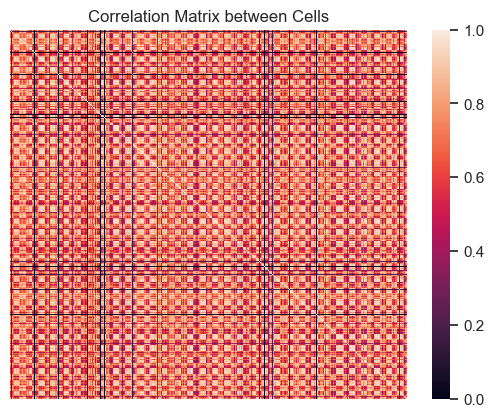

In [12]:
#represent cell_corr as a heat map
ax = plt.axes()
sns.heatmap(cell_corr, annot=False, xticklabels=False, yticklabels=False, ax=ax)
ax.set_title('Correlation Matrix between Cells')
plt.show()

In [13]:
cell_corr.describe()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                         383.000000          
mean                                            0.692450          
std                                             0.170704          
min                                             0.005703          
25%                                             0.604644          
50%                                             0.702281          
75%                                             0.816015          
max                                             1.000000          

       output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
count                                         383.000000          
mean                                            0.182000          
std                                             0.066285          
min                                            -0.000855          
25%                                             0.147678          
50%                                             0.183206          
75%                                             0.214738          
max                                             1.000000          

       output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
count                                         383.000000          
mean                                            0.666715          
std                                             0.169978          
min                                             0.000086          
25%                                             0.574979          
50%                                             0.641241          
75%                                             0.808728          
max                                             1.000000          

       output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
count                                         383.000000        
mean                                            0.678748        
std                                             0.129026        
min                                             0.011887        
25%                                             0.663855        
50%                                             0.705830        
75%                                             0.742279        
max                                             1.000000        

       output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
count                                         383.000000        
mean                                            0.725266        
std                                             0.208038        
min                                             0.004288        
25%                                             0.581749        
50%                                             0.764353        
75%                                             0.895716        
max                                             1.000000        

       output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
count                                         383.000000        
mean                                            0.721863        
std                                             0.220834        
min                                             0.004259        
25%                                             0.557009        
50%                                             0.752969        
75%                                             0.921878        
max                                             1.000000        

       output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
count                                         383.000000        
mean                                            0.732166        
std                                             0.175528        
min                                             0.008594        
25%                                             0.628897        
50%                                            

We look at the cells which have the highest and lowest average correlation value

In [14]:
# return the columns with the lowest mean
cell_corr.describe().loc['mean'].sort_values(ascending=True)

output.STAR.1_H1_Norm_S337_Aligned.sortedByCoord.out.bam     0.007892
output.STAR.1_H5_Norm_S341_Aligned.sortedByCoord.out.bam     0.017576
output.STAR.1_B9_Hypo_S75_Aligned.sortedByCoord.out.bam      0.017935
output.STAR.3_E3_Norm_S207_Aligned.sortedByCoord.out.bam     0.018205
output.STAR.1_G12_Hypo_S318_Aligned.sortedByCoord.out.bam    0.037414
                                                               ...   
output.STAR.1_G7_Hypo_S313_Aligned.sortedByCoord.out.bam     0.778235
output.STAR.1_G9_Hypo_S315_Aligned.sortedByCoord.out.bam     0.780139
output.STAR.3_G7_Hypo_S325_Aligned.sortedByCoord.out.bam     0.783244
output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam      0.787064
output.STAR.4_C7_Hypo_S139_Aligned.sortedByCoord.out.bam     0.789184
Name: mean, Length: 383, dtype: float64

In [ ]:
# return the list of correlations by absolute value
def get_correlations(corr, threshold):
    cor_list = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                cor_list.append([corr.columns[i], corr.columns[j], corr.iloc[i, j]])
    return cor_list

# sort 
sorted(get_correlations(cell_corr, 0.5), key=lambda x: x[2], reverse=True)

[['"output.STAR.4_F8_Hypo_S284_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.4_F7_Hypo_S283_Aligned.sortedByCoord.out.bam"',
  0.9955045107896693],
 ['"output.STAR.4_D5_Norm_S167_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_A3_Norm_S9_Aligned.sortedByCoord.out.bam"',
  0.9892120523390061],
 ['"output.STAR.3_A4_Norm_S16_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_F1_Norm_S247_Aligned.sortedByCoord.out.bam"',
  0.9860843502864391],
 ['"output.STAR.3_H4_Norm_S352_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_F1_Norm_S247_Aligned.sortedByCoord.out.bam"',
  0.9859694456677376],
 ['"output.STAR.4_F4_Norm_S262_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.2_C4_Norm_S106_Aligned.sortedByCoord.out.bam"',
  0.985598045640576],
 ['"output.STAR.1_H3_Norm_S339_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.1_E5_Norm_S197_Aligned.sortedByCoord.out.bam"',
  0.9850617557719057],
 ['"output.STAR.4_F5_Norm_S263_Aligned.sortedByCoord.out.bam"',
  '"output.STAR.4_D5_Norm_S167_Ali

## <u>Comparison between Datasets:</u>

## <u>Unsupervised Learning:</u>

## <u>Supervised Learning:</u>

### Defining general pipeline and evalution functions:

In [12]:
def tune_model(X, y, params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=None, verbose=1, sample_weights=None, probability=True, principal_metric='roc_auc', error_score=np.nan):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    if probability:
        scoring = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall']
    else: 
        scoring = ['accuracy', 'f1', 'precision', 'recall']
    principal_metric = principal_metric

    if hyperparameter_tuner == 'grid':
        search = GridSearchCV(pipeline, params, cv=cv, scoring=scoring, refit=principal_metric, n_jobs=-1, verbose=verbose, error_score=np.nan)
    elif hyperparameter_tuner == 'random':
        search = RandomizedSearchCV(pipeline, params, cv=cv, scoring=scoring, refit=principal_metric, n_iter=n_iter, n_jobs=-1, verbose=verbose, error_score=np.nan)
#    elif hyperparameter_tuner == 'bayes':
#        search = BayesSearchCV(pipeline, params, cv=cv, scoring=scoring, refit=principal_metric, n_iter=n_iter, n_jobs=-1, verbose=verbose, error_score=np.nan)
    else:
        raise ValueError(f"Unknown hyperparameter tuner: {hyperparameter_tuner}\n Choose from 'grid', 'random', 'bayes'")
    if sample_weights is not None:
        kwargs = {pipeline.steps[-1][0] + '__sample_weight': sample_weights}
        result = search.fit(X, y, **kwargs)
    else:
        result = search.fit(X, y)
    best_model = result.best_estimator_

    return result, best_model

In [13]:
def model_validation_performance(result, principal_metric='roc_auc',probability=True):
    print('')
    if probability:
        scoring = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall']
    else: 
        scoring = ['accuracy', 'f1', 'precision', 'recall']
    # order the list such that the principal metric is the first element
    scoring.insert(0, scoring.pop(scoring.index(principal_metric)))
    for i in scoring:
        if i == principal_metric:
            print(f'Best {i} score: {result.best_score_}')
            print('')
        print(f"Cross-validation {i} scores: {result.cv_results_['mean_test_'+i][result.best_index_]}\n")
    print(f"\nParameters for the best model: \n{result.best_params_}")

In [14]:
def plot_results(result, principal_metric='roc_auc'):
    # Extract the results into a pandas DataFrame
    results = pd.DataFrame(result.cv_results_)
    
    # Extract parameter names
    param_names = [col for col in results.columns if col.startswith('param_')]
    
    # Create subplots for each parameter
    num_params = len(param_names)
    fig, axs = plt.subplots(num_params, 1, figsize=(10, num_params * 4))
    
    # Ensure axs is a 1D array
    if num_params == 1:
        axs = [axs]
    
    for i, param in enumerate(param_names):
        param_values = results[param]
        mean_test_score = results[f'mean_test_{principal_metric}']
        
        # Create a dataframe for table and compute average scores for unique parameter values
        table_data = pd.DataFrame({
            param: param_values,
            f'mean_test_{principal_metric}': mean_test_score,
        })

        # Sort parameter values correctly if they are numerical
        try:     
            table_data[param] =  table_data[param].fillna(-1)   
            table_data[param] = table_data[param].astype(float)
        except (TypeError, ValueError):
            table_data[param] = table_data[param].astype(str)
        
        grouped_data = table_data.groupby(param).agg({
            f'mean_test_{principal_metric}': list,
        }).reset_index()
        
        grouped_data = grouped_data.sort_values(by=param)     
        sorted_param_values = grouped_data[param].replace([-1, "-1"], "N/A")
        
        # Plot mean test score using boxplot
        sns.boxplot(x=sorted_param_values, y=grouped_data[f'mean_test_{principal_metric}'].explode(), ax=axs[i], color='#8EC6FF', width=0.8)
        axs[i].set_title(f'Mean {principal_metric} score of {param}')
        axs[i].set_xlabel(param)
        axs[i].set_ylabel(f'Mean {principal_metric} score')
        axs[i].tick_params(axis='x', rotation=20)
        axs[i].format_coord = lambda x,y: '%3d, %3d' % (x,y)
    
    plt.tight_layout()
    plt.show()

In [15]:
def model_test_performance(name, best_model, X_test, y_test, probability=True):
    print(f'Evaluating the performance on the test set for {name}:\n')
    y_pred = best_model.predict(X_test)
    if probability:
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'ROC AUC: {roc_auc}')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # display confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    classes = ('Hypoxia', 'Normoxia')
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.title(f'Confusion matrix for {name}')
    plt.show()

In [16]:
# for each dataset we create a train-test split
X_train, X_test, y_train, y_test = {}, {}, {}, {}
for name, df in datasets.items():
    X = df.drop(columns=['target'])
    y = df['target']
    X_train[name], X_test[name], y_train[name], y_test[name] = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### XGBOOST:

We first run XGBOOST, a very popular and flexiblle ensemble learning technique based on decision trees 

In [ ]:
def xgb_pipe_params(X, y, n_estimators=200, balance=True):
    # find total negative and positive samples 
    total = len(y)
    total_positive = np.sum(y==1)
    total_negative = total - total_positive

    # set the scale pos weight
    scale_pos_weight = total_negative / total_positive if balance else 1

    # Define the pipeline steps
    xgb_pipeline = Pipeline([
        ('xgb', XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=n_estimators, device='cuda', n_jobs=-1, tree_method='hist'))  
    ])

    xgb_params = {
        'xgb__reg_alpha': [0.0, 1, 10, 100],
        'xgb__eta': [0.1, 0.3, 0.5],
        'xgb__colsample_bytree': [0.5, 1.0],
        'xgb__subsample': [0.5, 1.0],
        'xgb__colsample_bylevel': [0.5, 1.0]
    }

    return xgb_pipeline, xgb_params

In [ ]:
# Training the models
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    if (name == 'MCF7_SmartSeq') or (name == 'HCC1806_SmartSeq'):
        n_estimators = 100
    else:
        n_estimators = 1000
    pipeline, params = xgb_pipe_params(X_train[name], y_train[name], n_estimators=n_estimators, balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='roc_auc', error_score=np.nan)

    # save the model and the result
    model_name = f'xgboost_mkII_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'xgboost_mkII_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

In [21]:
# Evaluate the models in their k-fold cross-validation
for name, df in datasets.items():
    with open(f'results/xgboost_mkII_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=True)
    plot_results(result, principal_metric='roc_auc')
    print('-'*100)

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AttributeError: Can't get attribute '_ThresholdScorer' on <module 'sklearn.metrics._scorer' from 'c:\\Users\\Asus\\anaconda3\\Lib\\site-packages\\sklearn\\metrics\\_scorer.py'>

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for MCF7_SmartSeq:

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


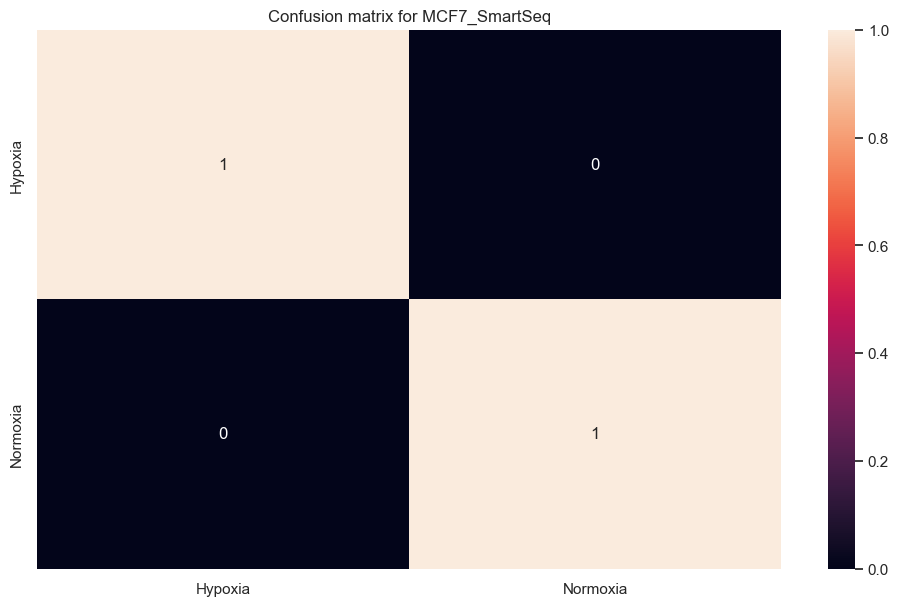

Evaluating the performance on the test set for HCC1806_SmartSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC AUC: 1.0
Accuracy: 0.972972972972973
F1: 0.9714285714285714
Precision: 0.9444444444444444
Recall: 1.0


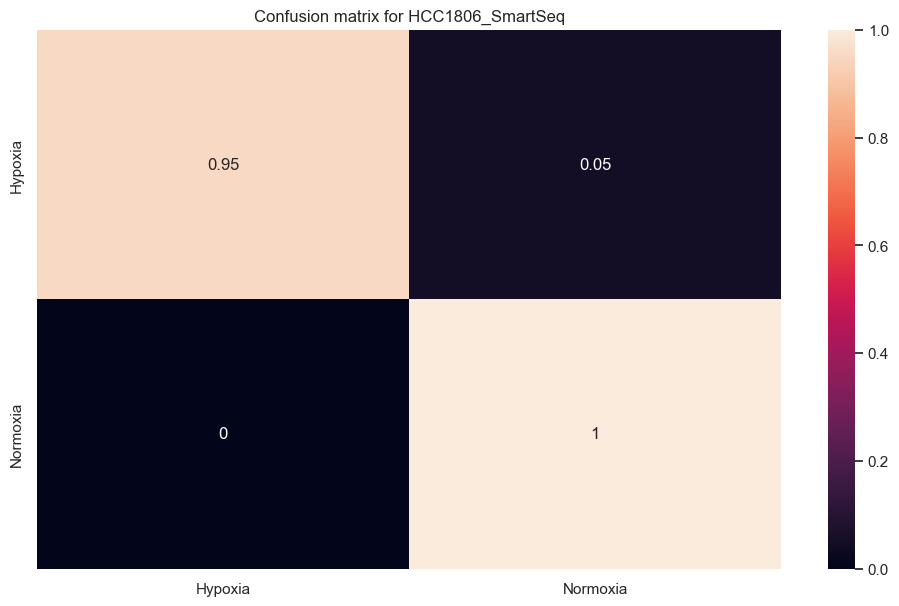

Evaluating the performance on the test set for MCF7_DropSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC AUC: 0.9959449259427517
Accuracy: 0.9817383263985205
F1: 0.9845128406194864
Precision: 0.9858657243816255
Recall: 0.9831636648394675


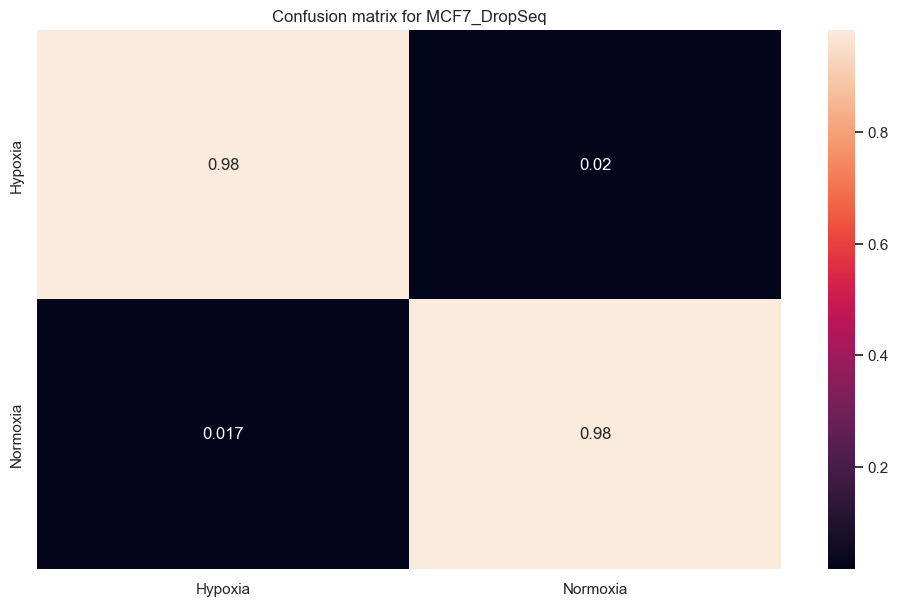

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for HCC1806_DropSeq:

ROC AUC: 0.991657950272446
Accuracy: 0.961525366019748
F1: 0.9514813224559897
Precision: 0.9502572898799314
Recall: 0.9527085124677558


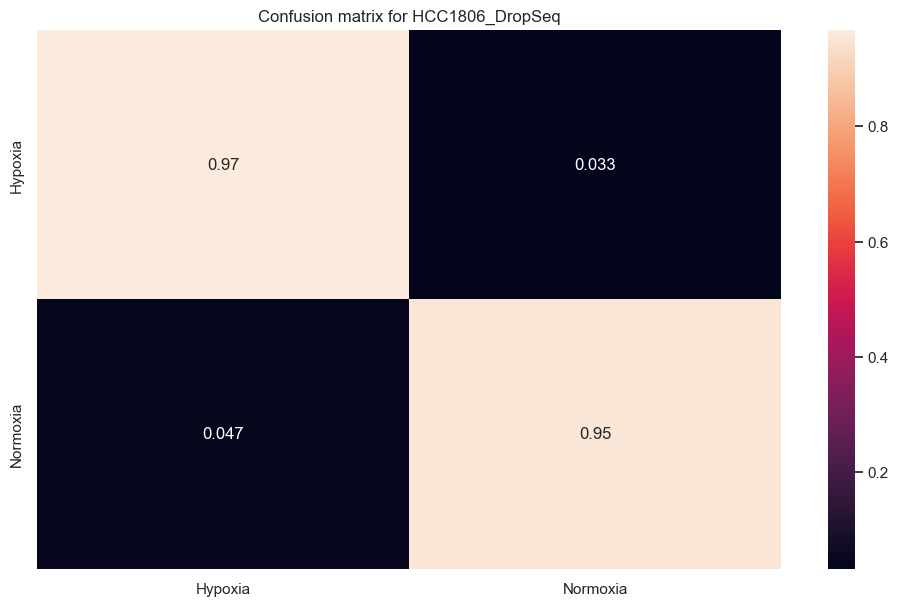

In [ ]:
# Evaluating the best models
for name, df in datasets.items():
    # load the model
    model_name = f'xgboost_mkII_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    # print percentage of true predicted positives
    model_test_performance(name, best_model, X_test[name], y_test[name])

&nbsp;

### RANDOM FOREST

In [ ]:
def rf_pipe_params(X, y, n_estimators=200, balance=True):
    # Define the pipeline steps
    rf_pipeline = Pipeline([
        ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=n_estimators, n_jobs=-1))  
    ])

    rf_params = {
        'rf__criterion': ['gini', 'entropy'],
        'rf__max_depth': [20, n_estimators*0.3, None],
        'rf__min_samples_split': [1, 5, 10],
        'rf__boostrap': [True, False]
    }
    return rf_pipeline, rf_params

In [ ]:
# Training the models
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    if (name == 'MCF7_SmartSeq') or (name == 'HCC1806_SmartSeq'):
        n_estimators = 100
    else:
        n_estimators = 1000
    pipeline, params = rf_pipe_params(X_train[name], y_train[name], n_estimators=n_estimators, balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='roc_auc', error_score=np.nan)

    # save the model and the result
    model_name = f'rf_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'rf_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Validating 

Best roc_auc score: 1.0

Cross-validation roc_auc scores: 1.0

Cross-validation accuracy scores: 0.9949999999999999

Cross-validation f1 scores: 0.9948717948717949

Cross-validation precision scores: 1.0

Cross-validation recall scores: 0.99


Parameters for the best model: 
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_split': 5}


C:\Users\Asus\AppData\Local\Temp\ipykernel_12368\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  table_data[param] =  table_data[param].fillna(-1)


ValueError: cannot reindex on an axis with duplicate labels

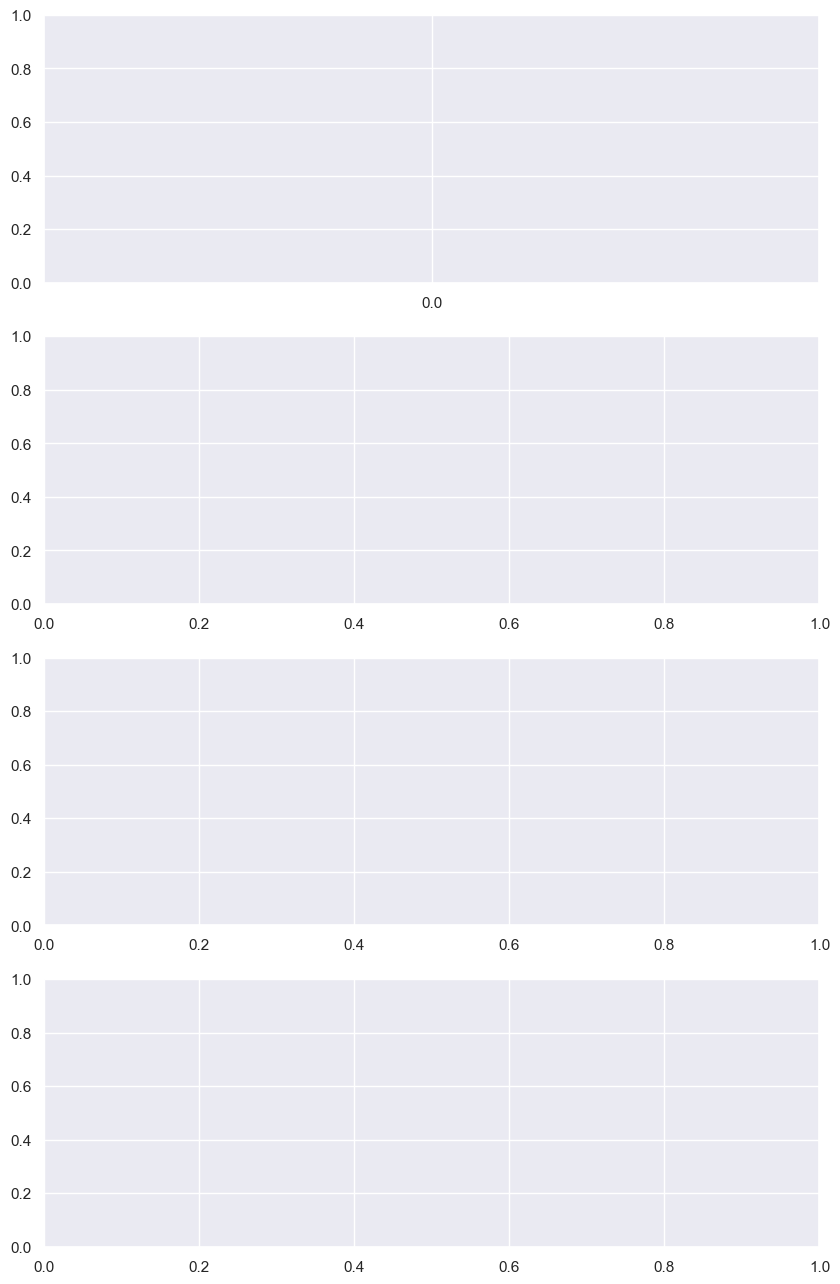

In [20]:
# Evaluate the models in their k-fold cross-validation
for name, df in datasets.items():
    print(f'Validating ')
    with open(f'results/rf_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=True)
    plot_results(result, principal_metric='roc_auc')
    print('-'*100)

Evaluating the performance on the test set for MCF7_SmartSeq:

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


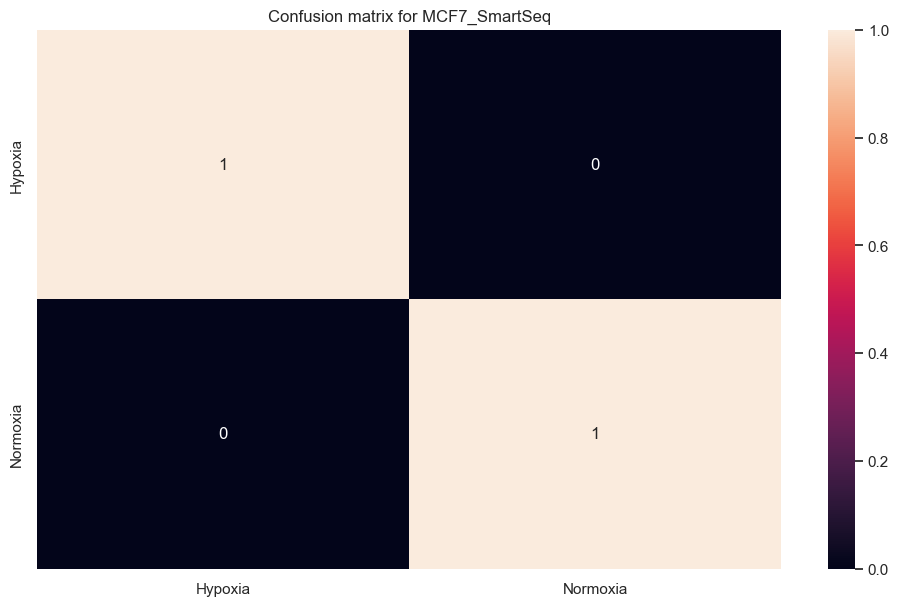

Evaluating the performance on the test set for HCC1806_SmartSeq:

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


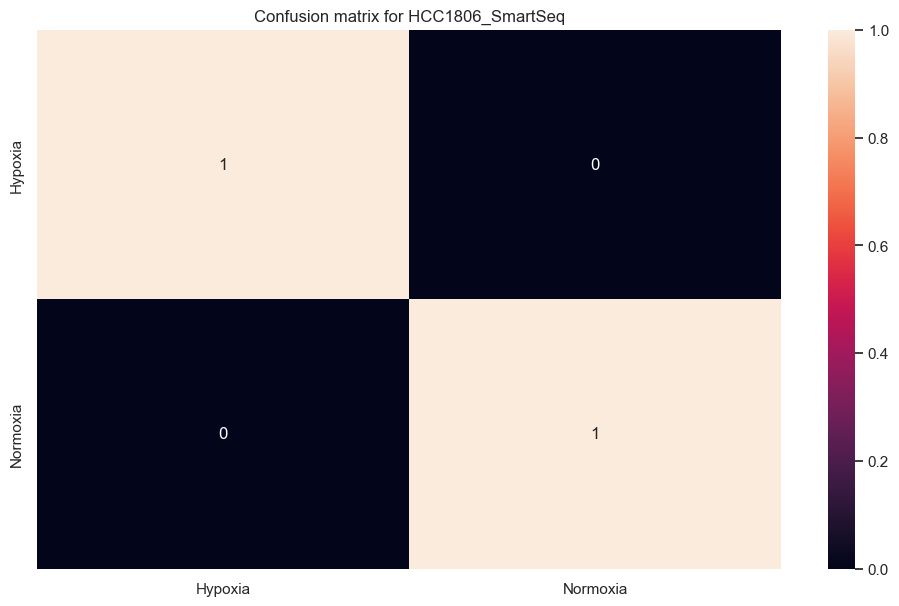

Evaluating the performance on the test set for MCF7_DropSeq:

ROC AUC: 0.9918332859003979
Accuracy: 0.9685621821544151
F1: 0.973724884080371
Precision: 0.9610983981693364
Recall: 0.9866875489428347


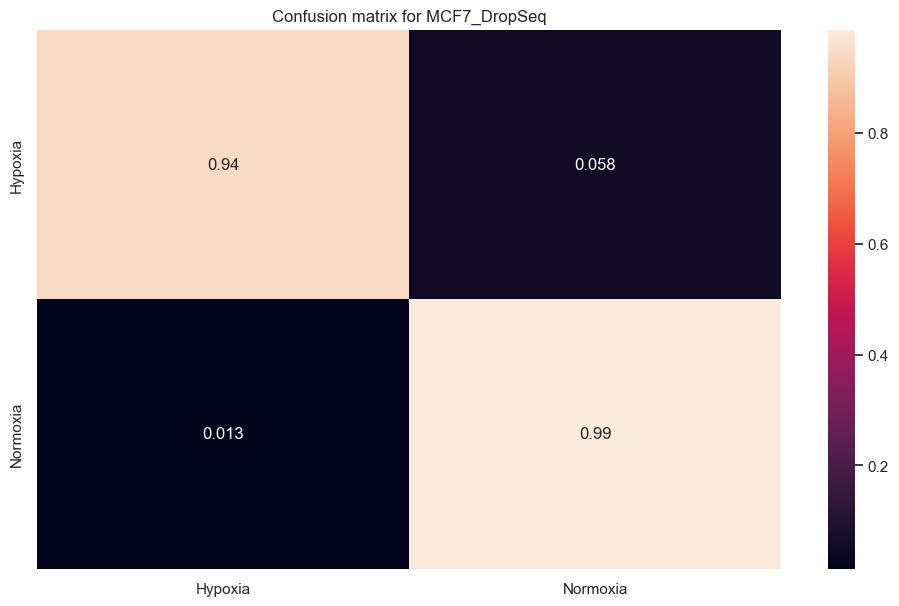

Evaluating the performance on the test set for HCC1806_DropSeq:

ROC AUC: 0.988629104258415
Accuracy: 0.9438202247191011
F1: 0.9261083743842364
Precision: 0.9663551401869159
Recall: 0.8890799656061908


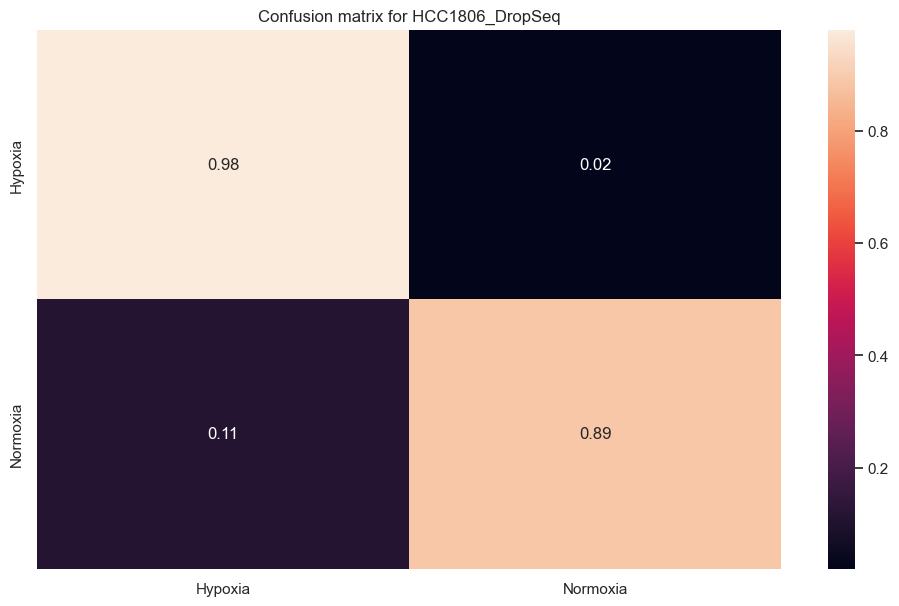

In [24]:
# Evaluating the best models
for name, df in datasets.items():
    # load the model
    model_name = f'rf_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name])

In [ ]:
with open(f'results/rf_result_HCC1806_DropSeq.pkl', 'rb') as f:
    g = pkl.load(f)

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

&nbsp;

### SUPPORT VECTOR MACHINES

In [ ]:
def svm_pipe_params(X, y, balance=True):
    # Define the pipeline steps
    svm_pipeline = Pipeline([
        ('svm', SVC(class_weight='balanced'))  
    ])

    svm_params = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svm__degree': [2, 5],
        'svm__gamma': ['scale', 'auto'],
        'svm__coef0': [0.0, 1.0]
    }
    return svm_pipeline, svm_params

In [ ]:
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    pipeline, params = svm_pipe_params(X_train[name], y_train[name], balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=False, principal_metric='accuracy', error_score=np.nan)

    # save the model and the result
    model_name = f'svm_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'svm_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Tuning MCF7_SmartSeq dataset
Fitting 15 folds for each of 128 candidates, totalling 1920 fits
Tuning HCC1806_SmartSeq dataset
Fitting 15 folds for each of 128 candidates, totalling 1920 fits
Tuning MCF7_DropSeq dataset
Fitting 15 folds for each of 128 candidates, totalling 1920 fits


In [ ]:
for name, df in datasets.items():
    with open(f'results/svm_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=False, principal_metric='accuracy')
    print('-'*100)


Best accuracy score: 1.0

Cross-validation accuracy scores: 1.0

Cross-validation f1 scores: 1.0

Cross-validation precision scores: 1.0

Cross-validation recall scores: 1.0


Parameters for the best model: 
{'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

The training of MCF7_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9793103448275862

Cross-validation accuracy scores: 0.9793103448275862

Cross-validation f1 scores: 0.9773358221174314

Cross-validation precision scores: 0.985982905982906

Cross-validation recall scores: 0.9699633699633701


Parameters for the best model: 
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

The training of HCC1806_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9789017341040461

Cross-validation accur

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info pleas

Evaluating the performance on the test set for MCF7_SmartSeq:

Accuracy: 0.98
F1: 0.9803921568627451
Precision: 0.9615384615384616
Recall: 1.0


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


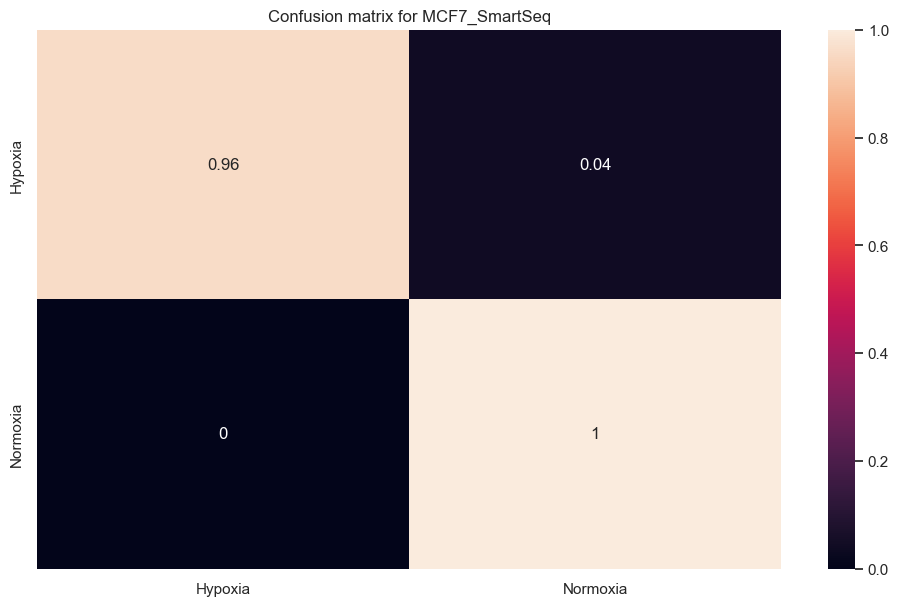

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for HCC1806_SmartSeq:

Accuracy: 0.972972972972973
F1: 0.9714285714285714
Precision: 0.9444444444444444
Recall: 1.0


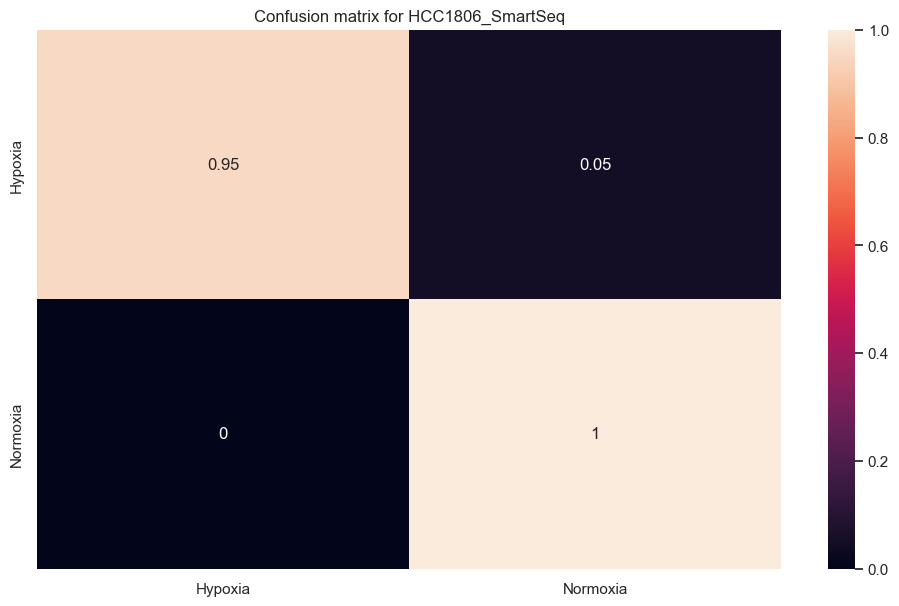

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for MCF7_DropSeq:

Accuracy: 0.9791955617198336
F1: 0.9823943661971831
Precision: 0.9816262705238468
Recall: 0.9831636648394675


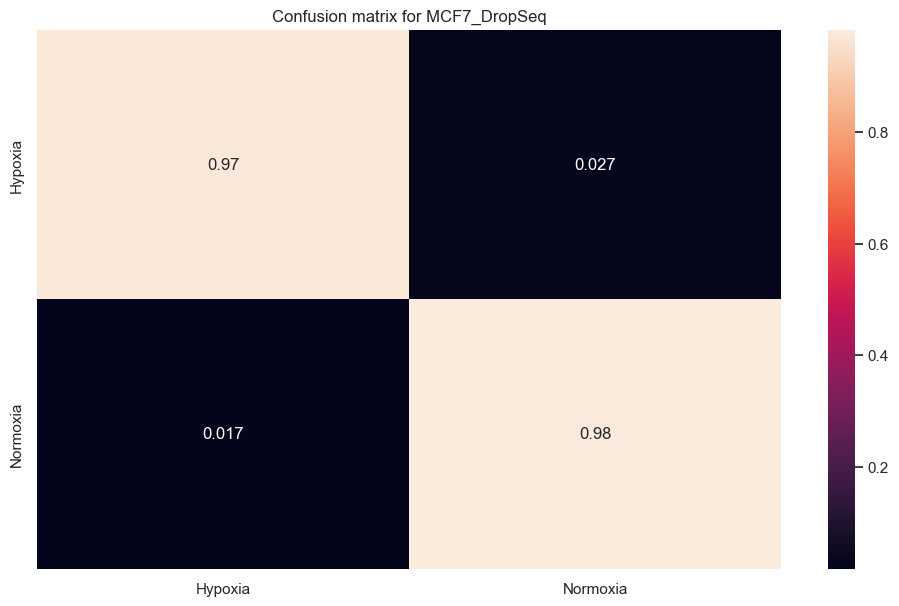

Evaluating the performance on the test set for HCC1806_DropSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy: 0.9540347293156282
F1: 0.9417350021579629
Precision: 0.9454072790294628
Recall: 0.938091143594153


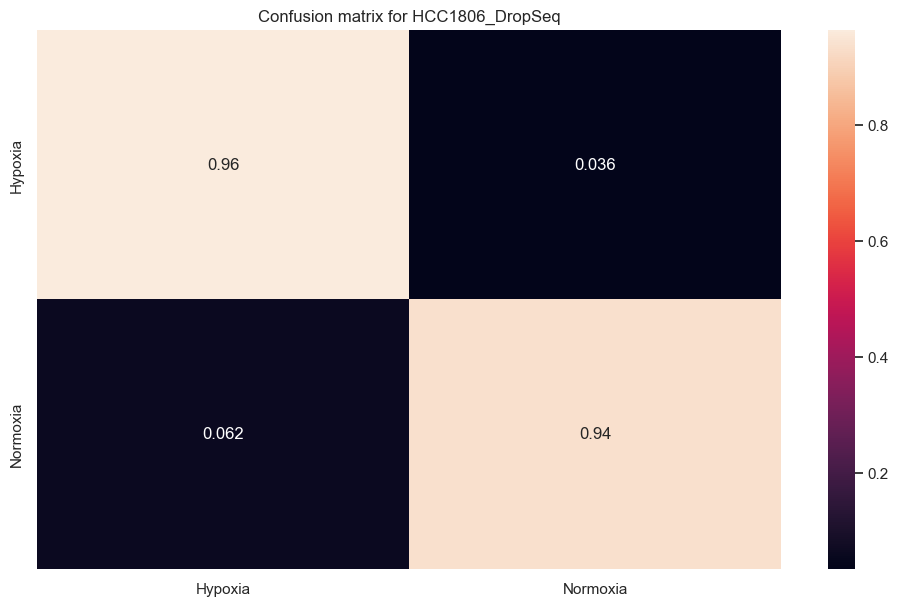

In [23]:
for name, df in datasets.items():
    # load the model
    model_name = f'svm_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name], probability=False)

&nbsp;

### SGD CLASSIFIER

In [ ]:
def sgd_pipe_params(X, y, balance=True):
    # Define the pipeline steps
    sgd_pipeline = Pipeline([
        ('sgd', SGDClassifier(class_weight='balanced'))  
    ])

    sgd_params =[{
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1'],
        'sgd__alpha': [0.001, 0.01, 0.1],
     },
    {
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['elasticnet'],
        'sgd__alpha': [0.001, 0.01, 0.1],
        'sgd__l1_ratio': [0.25, 0.5, 0.75]
    }]
    return sgd_pipeline, sgd_params

In [ ]:
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    pipeline, params = sgd_pipe_params(X_train[name], y_train[name], balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='accuracy', error_score=np.nan)

    # save the model and the result
    model_name = f'sgd_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'sgd_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Tuning MCF7_SmartSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning HCC1806_SmartSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning MCF7_DropSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning HCC1806_DropSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits


In [ ]:
for name, df in datasets.items():
    with open(f'results/sgd_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=False, principal_metric='accuracy')
    print('-'*100)


Best accuracy score: 0.9983333333333333

Cross-validation accuracy scores: 0.9983333333333333

Cross-validation f1 scores: 0.9983739837398374

Cross-validation precision scores: 0.9968253968253968

Cross-validation recall scores: 1.0


Parameters for the best model: 
{'sgd__alpha': 0.001, 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}

The training of MCF7_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9701149425287354

Cross-validation accuracy scores: 0.9701149425287354

Cross-validation f1 scores: 0.969386177891925

Cross-validation precision scores: 0.9563492063492064

Cross-validation recall scores: 0.9857142857142858


Parameters for the best model: 
{'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'hinge', 'sgd__penalty': 'elasticnet'}

The training of HCC1806_SmartSeq is done, saving the model


-----------------------------------------------------------------

Evaluating the performance on the test set for MCF7_SmartSeq:

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


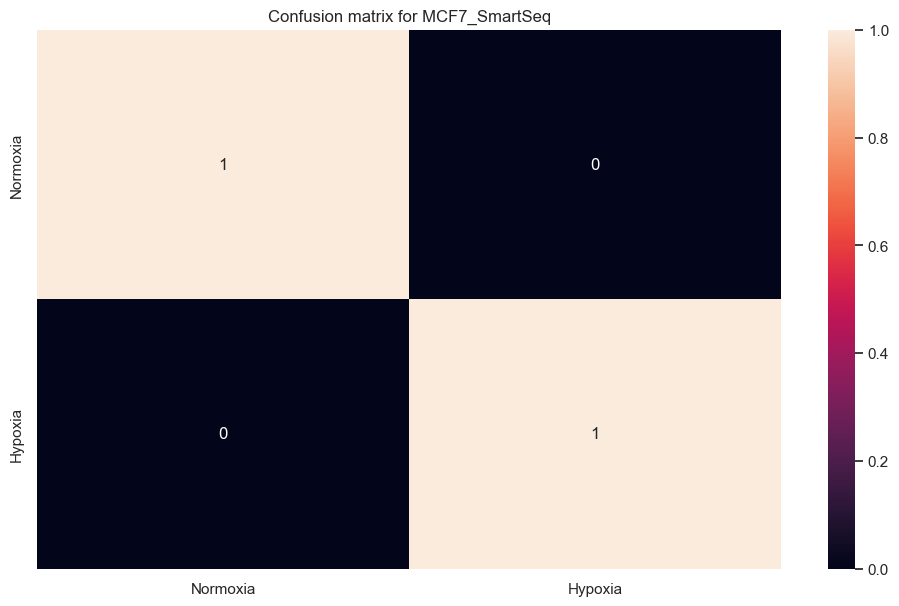

Evaluating the performance on the test set for HCC1806_SmartSeq:

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


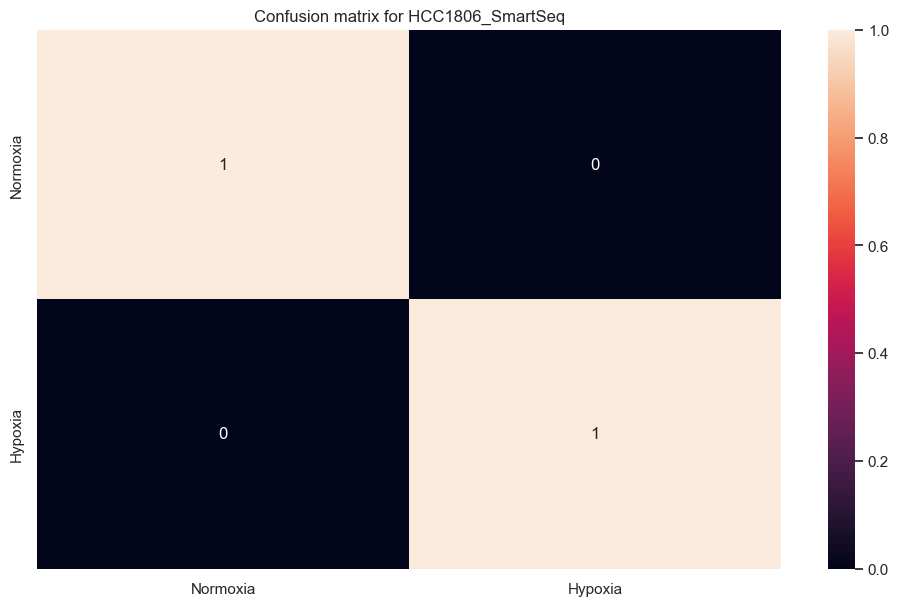

Evaluating the performance on the test set for MCF7_DropSeq:

Accuracy: 0.9699491447064262
F1: 0.9747180085569818
Precision: 0.9683153013910355
Recall: 0.9812059514487079


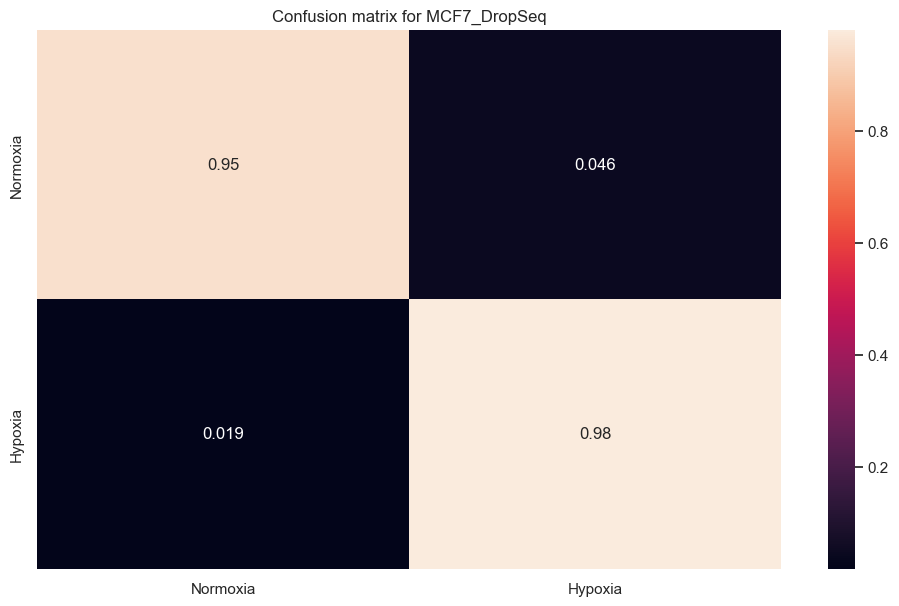

Evaluating the performance on the test set for HCC1806_DropSeq:

Accuracy: 0.9410963568266939
F1: 0.9275847634993721
Precision: 0.9037520391517129
Recall: 0.9527085124677558


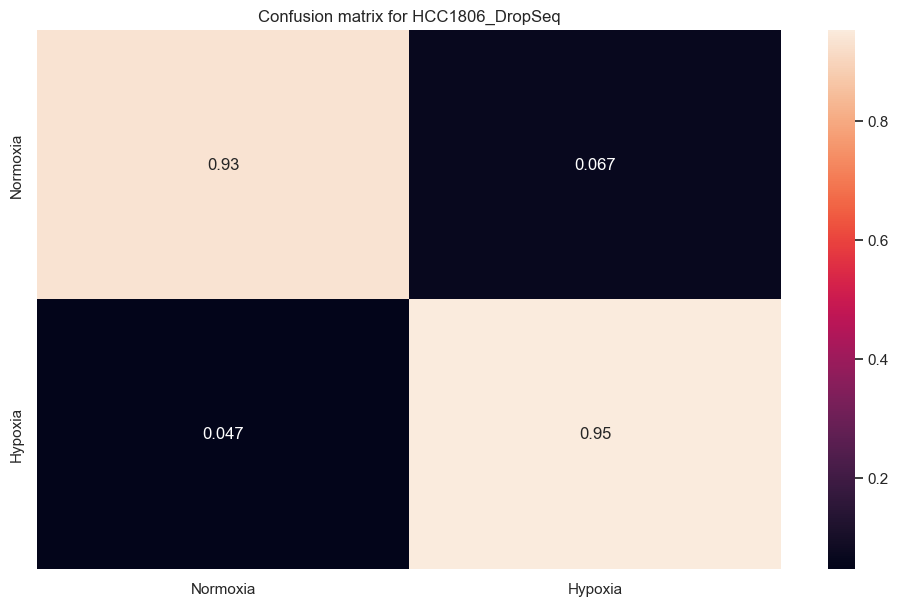

In [ ]:
for name, df in datasets.items():
    # load the model
    model_name = f'sgd_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name], probability=False)

### Training Neural Networks

#### KAN Class

In [25]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

#### Train-Test Split

In [26]:
datasets_train = {}
datasets_test = {}

for name, dataset in datasets.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_train[name] = train_dataset.astype(np.int32)
    datasets_test[name] = test_dataset.astype(np.int32)

datasets_labeled_smartS_mcf_train = {}
datasets_labeled_smartS_mcf_test = {}

for name, dataset in datasets_labeled_smartS_mcf.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_labeled_smartS_mcf_train[name] = train_dataset.astype(np.int32)
    datasets_labeled_smartS_mcf_test[name] = test_dataset.astype(np.int32)

merged_train_dataset = pd.concat(datasets_train.values()).fillna(0).astype(np.int32)
merged_test_dataset = pd.concat(datasets_test.values()).fillna(0).astype(np.int32)

merged_labeled_smartS_mcf_train_dataset = pd.concat(datasets_labeled_smartS_mcf_train.values()).fillna(0).astype(np.int32)
merged_labeled_smartS_mcf_test_dataset = pd.concat(datasets_labeled_smartS_mcf_test.values()).fillna(0).astype(np.int32)

#### Dataloader Setup

In [ ]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(1 if self.idx[index] in self.data_norm else 0,  dtype=torch.float32, device=device)
        return x, y

In [ ]:
data_loaders_train = {}
data_loaders_test = {}

for name in datasets_train.keys():
    data_loaders_train[name] = DataLoader(NNDataset(datasets_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_test[name] = DataLoader(NNDataset(datasets_test[name], merged_norm_idx), batch_size=32)

merged_data_loader_train = DataLoader(NNDataset(merged_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_test = DataLoader(NNDataset(merged_test_dataset, merged_norm_idx), batch_size=64)

data_loaders_labeled_smartS_mcf_train = {}
data_loaders_labeled_smartS_mcf_test = {}

for name in datasets_train.keys():
    data_loaders_labeled_smartS_mcf_train[name] = DataLoader(NNDataset(datasets_labeled_smartS_mcf_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_labeled_smartS_mcf_test[name] = DataLoader(NNDataset(datasets_labeled_smartS_mcf_test[name], merged_norm_idx), batch_size=32)

merged_data_loader_labeled_smartS_mcf_train = DataLoader(NNDataset(merged_labeled_smartS_mcf_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_labeled_smartS_mcf_test = DataLoader(NNDataset(merged_labeled_smartS_mcf_test_dataset, merged_norm_idx), batch_size=64)

#### Define Neural Networks

In [ ]:
class NNBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNBig, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class NNMedium(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNMedium, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class KANBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANBig, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class KANSmall(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANSmall, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class KANTiny(nn.Module):
    def __init__(self, in_size, H1):
        super(KANTiny, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, 1))

    def forward(self, x):
        return self.layers(x)

#### Helpers

##### Model Measuring

In [ ]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Hypoxia', 'Normoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)

In [ ]:
@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Hypoxia', 'Normoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.show()

##### Training Helpers

In [ ]:
def train(model, train_config, writer=None):
    total_epochs = 0
    for config_type, config in train_config:
        if config_type == 0:
            iter_count, subtrain_config = config
            for _ in range(iter_count):
                total_epochs += train(model, subtrain_config, writer)
        elif config_type == 1:
            num_epochs, data_loader, test_loader, optimizer, criterion = config
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs[:, 0], labels)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                    optimizer.step()
                    running_loss += loss.item()

                writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
                measure_model_log(writer, model, test_loader, total_epochs)
                writer.flush()
                total_epochs += 1
        else:
            raise Exception("Invalid training config")
    return total_epochs
        

In [ ]:
#lr_sgd = 1e-2
#lr_ada = 1e-2
#lr_admw = 1e-3
#wd_admw = 1e-4

# Define the optimizer
#sgd = optim.SGD(model.parameters(), lr=lr_sgd)
#adm = optim.Adam(model.parameters(), lr=lr_adm)
#ada = optim.Adagrad(model.parameters(), lr=lr_ada)
#admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

#### Training Neural Networks

##### Training Over Individual Datasets

In [ ]:
input_size = 3000

###### Traditional Neural Networks

In [ ]:
models = {}
for name in data_loaders_test.keys():
    model = NNMedium(input_size, 4096, 1024, 512).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

In [ ]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [ ]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

###### KAN (Kolmogorov Arnold Networks)

In [ ]:
models = {}
for name in data_loaders_test.keys():
    model = KANTiny(input_size, 64).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 133.2124786376953
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  2%|▏         | 1/50 [00:00<00:33,  1.46it/s]

Epoch 2, Loss: 6.825803354382515
F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%


  4%|▍         | 2/50 [00:00<00:21,  2.28it/s]

Epoch 3, Loss: 7.255246892571449


  6%|▌         | 3/50 [00:01<00:16,  2.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.0


  8%|▊         | 4/50 [00:01<00:14,  3.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.0


 10%|█         | 5/50 [00:01<00:12,  3.49it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.47736334800720215


 12%|█▏        | 6/50 [00:01<00:12,  3.65it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.0


 14%|█▍        | 7/50 [00:02<00:11,  3.65it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.0


 16%|█▌        | 8/50 [00:02<00:11,  3.78it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0


 18%|█▊        | 9/50 [00:02<00:10,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.0


 20%|██        | 10/50 [00:02<00:10,  3.93it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 11, Loss: 5.133291340264616e-28
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 22%|██▏       | 11/50 [00:03<00:11,  3.40it/s]

Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:03<00:10,  3.64it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:03<00:09,  3.81it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.2489517778158188


 28%|██▊       | 14/50 [00:04<00:09,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 15, Loss: 9.49437141418457


 30%|███       | 15/50 [00:04<00:08,  4.04it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:08,  4.13it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:07,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:07,  4.08it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 19, Loss: 0.4927588999271393


 38%|███▊      | 19/50 [00:05<00:07,  4.13it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 0.0


 40%|████      | 20/50 [00:05<00:07,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:05<00:06,  4.23it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:05<00:06,  4.24it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 0.0


 46%|████▌     | 23/50 [00:06<00:06,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:06<00:06,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:06<00:05,  4.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:06<00:05,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 54%|█████▍    | 27/50 [00:07<00:06,  3.37it/s]

Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:06,  3.60it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:07<00:05,  3.65it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:08<00:05,  3.80it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:08<00:04,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:08<00:04,  4.01it/s]

F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%
Epoch 34, Loss: 0.0424070879817009


 68%|██████▊   | 34/50 [00:08<00:03,  4.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:09<00:03,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 0.0


 72%|███████▏  | 36/50 [00:09<00:03,  4.18it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:03,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:09<00:02,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 2.034475564956665


 78%|███████▊  | 39/50 [00:10<00:02,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:10<00:02,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:10<00:02,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:10<00:01,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:11<00:01,  4.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:11<00:01,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  4.21it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:11<00:00,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.0


 94%|█████████▍| 47/50 [00:12<00:00,  4.18it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:12<00:00,  4.17it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 98%|█████████▊| 49/50 [00:12<00:00,  3.26it/s]

Epoch 50, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 773.0351765950521


  2%|▏         | 1/50 [00:00<00:13,  3.73it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 54.054054054054056%
Epoch 2, Loss: 397.13902791341144


  4%|▍         | 2/50 [00:00<00:11,  4.12it/s]

F1 Score: 0.7555555555555555
Recall: 1.0
Accuracy on test: 70.27027027027027%
Epoch 3, Loss: 174.55777994791666


  6%|▌         | 3/50 [00:00<00:11,  4.25it/s]

F1 Score: 0.8387096774193549
Recall: 0.7647058823529411
Accuracy on test: 86.48648648648648%
Epoch 4, Loss: 21.20755608876546


  8%|▊         | 4/50 [00:00<00:10,  4.33it/s]

F1 Score: 0.9032258064516129
Recall: 0.8235294117647058
Accuracy on test: 91.8918918918919%
Epoch 5, Loss: 31.64124631881714


 10%|█         | 5/50 [00:01<00:10,  4.34it/s]

F1 Score: 0.8292682926829268
Recall: 1.0
Accuracy on test: 81.08108108108108%
Epoch 6, Loss: 15.96223751703898


 12%|█▏        | 6/50 [00:01<00:10,  4.39it/s]

F1 Score: 0.8666666666666667
Recall: 0.7647058823529411
Accuracy on test: 89.1891891891892%
Epoch 7, Loss: 1.1524152345955372


 14%|█▍        | 7/50 [00:01<00:09,  4.38it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 8, Loss: 5.846139550209045


 16%|█▌        | 8/50 [00:01<00:09,  4.33it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 9, Loss: 2.207048942645391


 18%|█▊        | 9/50 [00:02<00:09,  4.38it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 10, Loss: 0.38903455932935077


 20%|██        | 10/50 [00:02<00:09,  4.35it/s]

F1 Score: 0.9090909090909091
Recall: 0.8823529411764706
Accuracy on test: 91.8918918918919%
Epoch 11, Loss: 3.3109321296215057


 22%|██▏       | 11/50 [00:02<00:09,  4.24it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.27018853028615314


 24%|██▍       | 12/50 [00:02<00:08,  4.25it/s]

F1 Score: 0.8125
Recall: 0.7647058823529411
Accuracy on test: 83.78378378378379%
Epoch 13, Loss: 3.8832060943047204


 26%|██▌       | 13/50 [00:03<00:08,  4.29it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 14, Loss: 0.1456584334373474


 28%|██▊       | 14/50 [00:03<00:08,  4.38it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 15, Loss: 0.20798651377360025


 30%|███       | 15/50 [00:03<00:08,  4.37it/s]

F1 Score: 0.7142857142857143
Recall: 0.5882352941176471
Accuracy on test: 78.37837837837837%
Epoch 16, Loss: 2.815504719813665


 32%|███▏      | 16/50 [00:03<00:07,  4.40it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 17, Loss: 0.24404455224672952


 34%|███▍      | 17/50 [00:03<00:07,  4.41it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 18, Loss: 0.16553865373134613


 36%|███▌      | 18/50 [00:04<00:07,  4.45it/s]

F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%
Epoch 19, Loss: 0.32665349543094635


 38%|███▊      | 19/50 [00:04<00:06,  4.45it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.16819933553536734


 40%|████      | 20/50 [00:04<00:06,  4.47it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 21, Loss: 0.2601218471924464


 42%|████▏     | 21/50 [00:04<00:06,  4.45it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.15537661810715994


 44%|████▍     | 22/50 [00:05<00:06,  4.30it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 23, Loss: 0.18373181174198785


 46%|████▌     | 23/50 [00:05<00:06,  4.36it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 24, Loss: 0.12328000615040462
F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%


 48%|████▊     | 24/50 [00:05<00:08,  3.23it/s]

Epoch 25, Loss: 0.1406727929910024


 50%|█████     | 25/50 [00:06<00:07,  3.51it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 26, Loss: 0.32661337219178677


 52%|█████▏    | 26/50 [00:06<00:06,  3.75it/s]

F1 Score: 0.8947368421052632
Recall: 1.0
Accuracy on test: 89.1891891891892%
Epoch 27, Loss: 0.15269720057646433


 54%|█████▍    | 27/50 [00:06<00:05,  3.97it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 28, Loss: 0.15221941967805228


 56%|█████▌    | 28/50 [00:06<00:05,  4.11it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 29, Loss: 0.1477100575963656


 58%|█████▊    | 29/50 [00:06<00:05,  4.14it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 30, Loss: 0.11516040315230687


 60%|██████    | 30/50 [00:07<00:04,  4.16it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 31, Loss: 0.24868729213873544


 62%|██████▏   | 31/50 [00:07<00:04,  4.22it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 32, Loss: 0.14590618014335632
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 64%|██████▍   | 32/50 [00:07<00:04,  4.09it/s]

Epoch 33, Loss: 0.10313827047745387


 66%|██████▌   | 33/50 [00:07<00:04,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.1298671414454778


 68%|██████▊   | 34/50 [00:08<00:03,  4.19it/s]

F1 Score: 0.7333333333333333
Recall: 0.6470588235294118
Accuracy on test: 78.37837837837837%
Epoch 35, Loss: 0.6145521203676859


 70%|███████   | 35/50 [00:08<00:03,  4.23it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 36, Loss: 0.08040859798590343
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 72%|███████▏  | 36/50 [00:08<00:03,  4.15it/s]

Epoch 37, Loss: 0.10848275323708852
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 74%|███████▍  | 37/50 [00:08<00:03,  4.10it/s]

Epoch 38, Loss: 0.06711588116983573


 76%|███████▌  | 38/50 [00:09<00:02,  4.20it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 39, Loss: 0.10084181030591328


 78%|███████▊  | 39/50 [00:09<00:02,  4.22it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 40, Loss: 0.09724872807661693


 80%|████████  | 40/50 [00:09<00:02,  4.27it/s]

F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%
Epoch 41, Loss: 0.07584023972352345


 82%|████████▏ | 41/50 [00:09<00:02,  4.28it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 42, Loss: 0.09392853329579036
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 84%|████████▍ | 42/50 [00:10<00:01,  4.04it/s]

Epoch 43, Loss: 0.07498551284273465


 86%|████████▌ | 43/50 [00:10<00:01,  4.12it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 44, Loss: 0.10314223666985829


 88%|████████▊ | 44/50 [00:10<00:01,  4.20it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 45, Loss: 0.11442452669143677


 90%|█████████ | 45/50 [00:10<00:01,  4.27it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 46, Loss: 0.09705450137456258


 92%|█████████▏| 46/50 [00:10<00:00,  4.30it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 47, Loss: 0.07561613991856575


 94%|█████████▍| 47/50 [00:11<00:00,  4.26it/s]

F1 Score: 0.9090909090909091
Recall: 0.8823529411764706
Accuracy on test: 91.8918918918919%
Epoch 48, Loss: 0.04553971625864506
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 96%|█████████▌| 48/50 [00:11<00:00,  4.14it/s]

Epoch 49, Loss: 0.11197315156459808


 98%|█████████▊| 49/50 [00:11<00:00,  4.20it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 50, Loss: 0.09427482883135478


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.10952471519349576


 33%|███▎      | 1/3 [00:07<00:14,  7.30s/it]

F1 Score: 0.9823943661971831
Recall: 0.9831636648394675
Accuracy on test: 97.91955617198336%
Epoch 2, Loss: 0.06209442095755431


 67%|██████▋   | 2/3 [00:13<00:06,  6.83s/it]

F1 Score: 0.98359375
Recall: 0.9859044635865309
Accuracy on test: 98.05825242718447%
Epoch 3, Loss: 0.05378787876776939


100%|██████████| 3/3 [00:20<00:00,  6.76s/it]

F1 Score: 0.9853487009181481
Recall: 0.9874706342991386
Accuracy on test: 98.26629680998613%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.19780760481143775


 33%|███▎      | 1/3 [00:05<00:10,  5.49s/it]

F1 Score: 0.9315789473684211
Recall: 0.9131556319862425
Accuracy on test: 94.68845760980592%
Epoch 2, Loss: 0.09927563231600367


 67%|██████▋   | 2/3 [00:09<00:04,  4.73s/it]

F1 Score: 0.9460154241645244
Recall: 0.9492691315563199
Accuracy on test: 95.70990806945862%
Epoch 3, Loss: 0.08053902979008853
F1 Score: 0.9474576271186441
Recall: 0.9613069647463457
Accuracy on test: 95.77800476676882%


100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


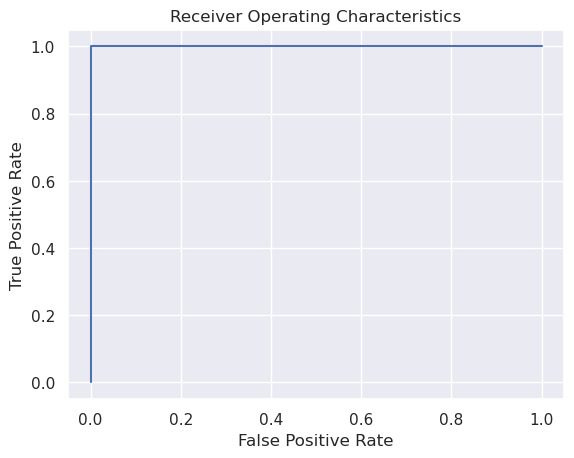

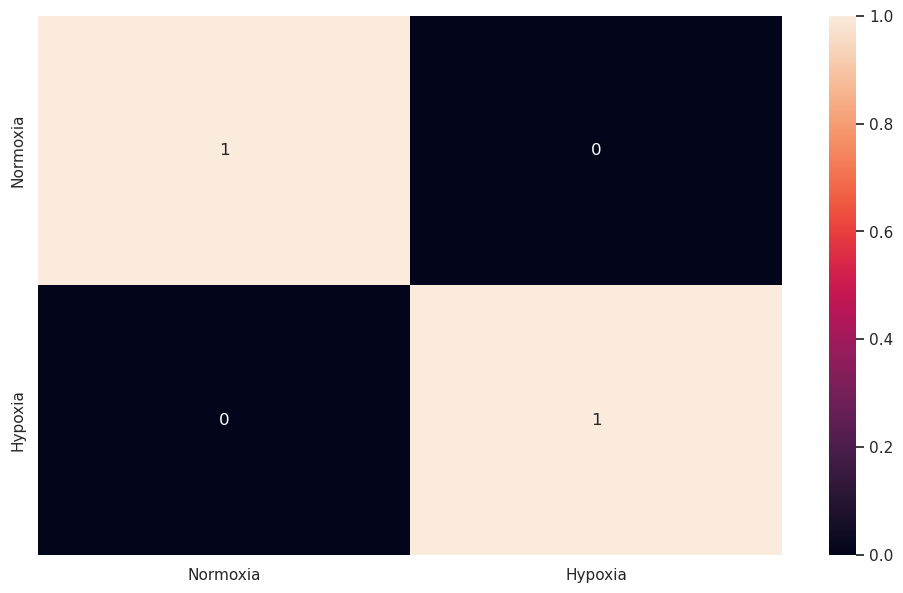

HCC1806_SmartSeq
F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%


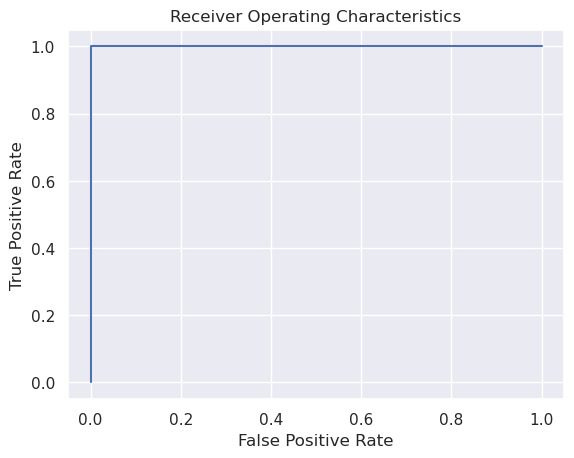

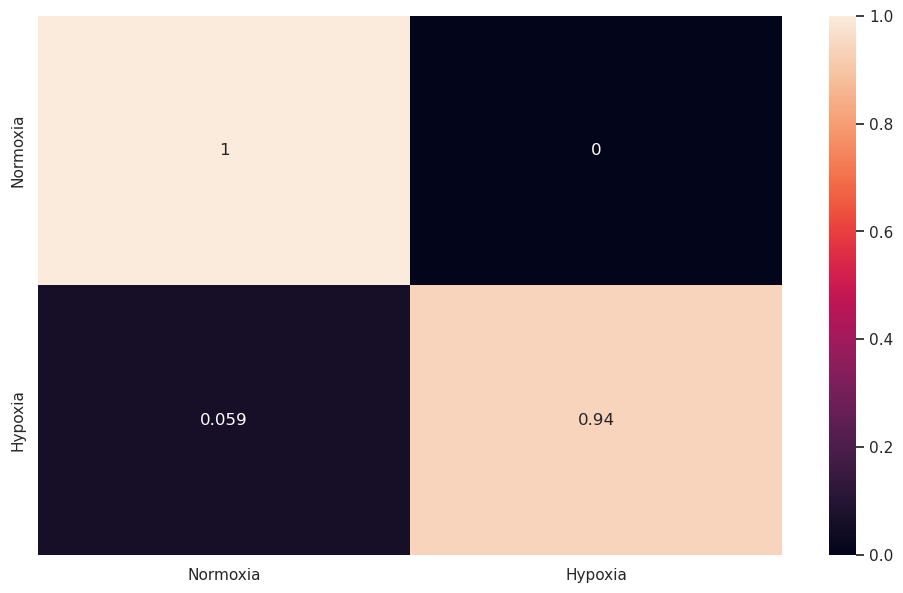

MCF7_DropSeq
F1 Score: 0.9851504493942946
Recall: 0.9870790916209867
Accuracy on test: 98.24318076745261%


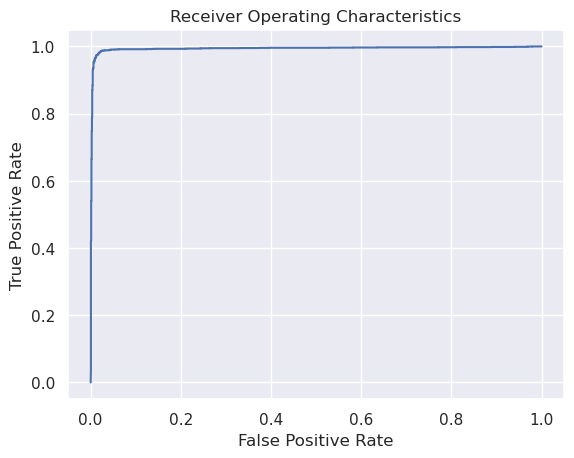

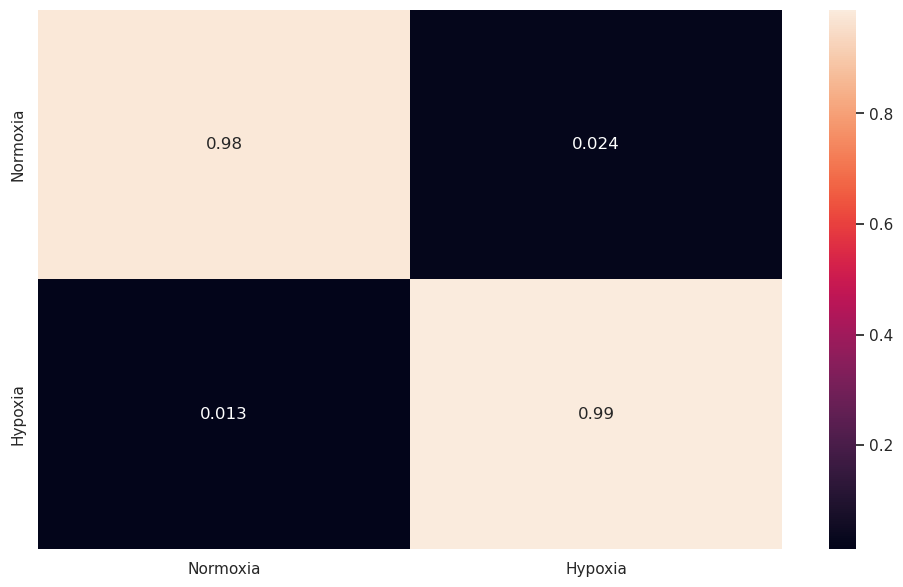

HCC1806_DropSeq
F1 Score: 0.942120828052387
Recall: 0.9587274290627688
Accuracy on test: 95.33537623425264%


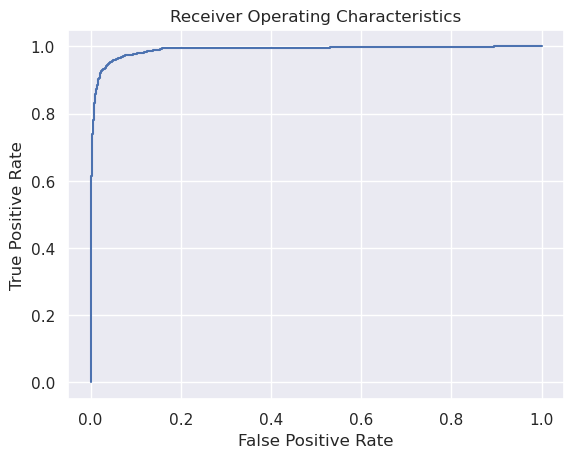

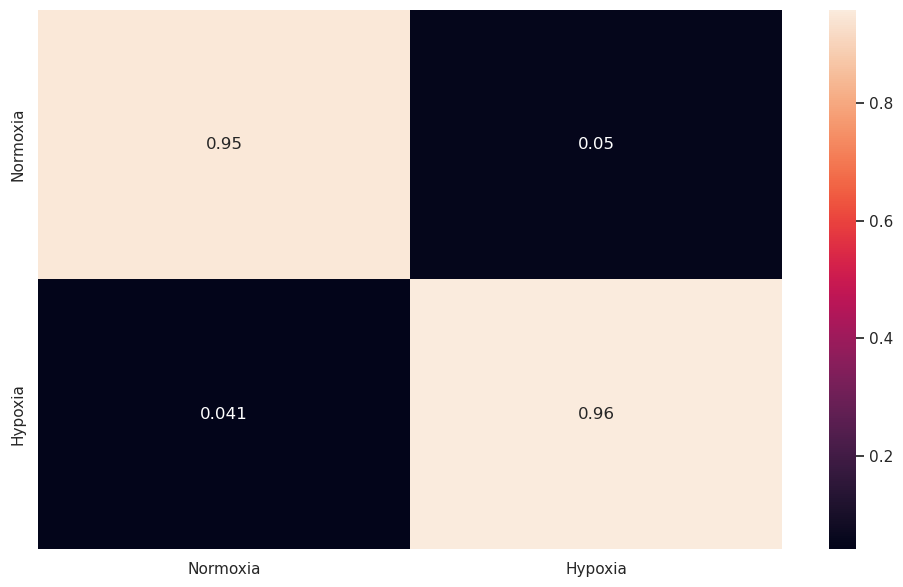

In [ ]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [ ]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

##### Training Over Merged Datasets

In [ ]:
input_size = merged_labeled_smartS_mcf_train_dataset.shape[1]

###### Traditional Neural Network

In [ ]:
model = NNBig(input_size, 4096, 2048, 1024).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [ ]:
train_config = [
    [1, [10, merged_data_loader_labeled_smartS_mcf_train, merged_data_loader_labeled_smartS_mcf_test, ada, bcelogits]]
]

In [ ]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 2097.71841102087


 10%|█         | 1/10 [00:18<02:44, 18.23s/it]

F1 Score: 0.9654803318169655
Recall: 0.959829741952647
Accuracy on test: 96.48979591836735%
Epoch 2, Loss: 0.11302491271584902


 20%|██        | 2/10 [00:36<02:25, 18.25s/it]

F1 Score: 0.9658743858717301
Recall: 0.9675445597233306
Accuracy on test: 96.50340136054422%
Epoch 3, Loss: 0.49561694710858356


 30%|███       | 3/10 [00:54<02:07, 18.15s/it]

F1 Score: 0.9693349263241736
Recall: 0.9712689545091779
Accuracy on test: 96.85714285714285%
Epoch 4, Loss: 0.04392177121974426


 40%|████      | 4/10 [01:12<01:49, 18.19s/it]

F1 Score: 0.9664268585131894
Recall: 0.9648842777334398
Accuracy on test: 96.57142857142857%
Epoch 5, Loss: 0.638812300781335


 50%|█████     | 5/10 [01:31<01:31, 18.26s/it]

F1 Score: 0.96513470681458
Recall: 0.9720670391061452
Accuracy on test: 96.40816326530613%
Epoch 6, Loss: 0.022606546616191776


 60%|██████    | 6/10 [01:49<01:13, 18.32s/it]

F1 Score: 0.966094934184284
Recall: 0.9664804469273743
Accuracy on test: 96.53061224489797%
Epoch 7, Loss: 0.1164736158216001


 70%|███████   | 7/10 [02:08<00:55, 18.38s/it]

F1 Score: 0.9670825590655694
Recall: 0.9691407289172652
Accuracy on test: 96.62585034013605%
Epoch 8, Loss: 0.16651503307147922


 80%|████████  | 8/10 [02:26<00:36, 18.42s/it]

F1 Score: 0.9660790598290598
Recall: 0.9622239957435488
Accuracy on test: 96.54421768707483%
Epoch 9, Loss: 0.26326096631421697


 90%|█████████ | 9/10 [02:45<00:18, 18.46s/it]

F1 Score: 0.9675167785234899
Recall: 0.9587656291566906
Accuracy on test: 96.70748299319727%
Epoch 10, Loss: 0.09256869295187962
F1 Score: 0.9652231845436375
Recall: 0.9635541367384943
Accuracy on test: 96.44897959183673%


100%|██████████| 10/10 [03:03<00:00, 18.40s/it]


10

F1 Score: 0.9655908242197919
Recall: 0.9630220803405161
Accuracy on test: 96.48979591836735%


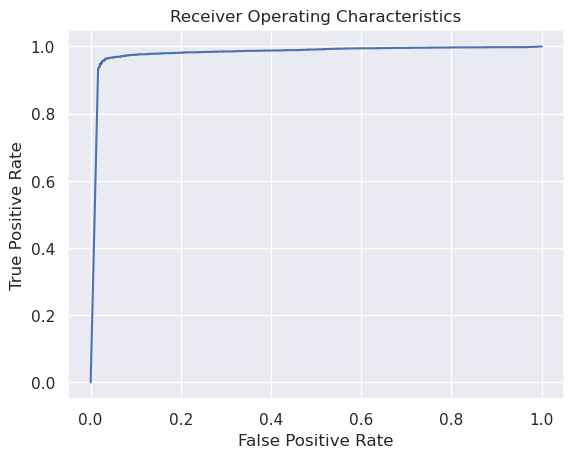

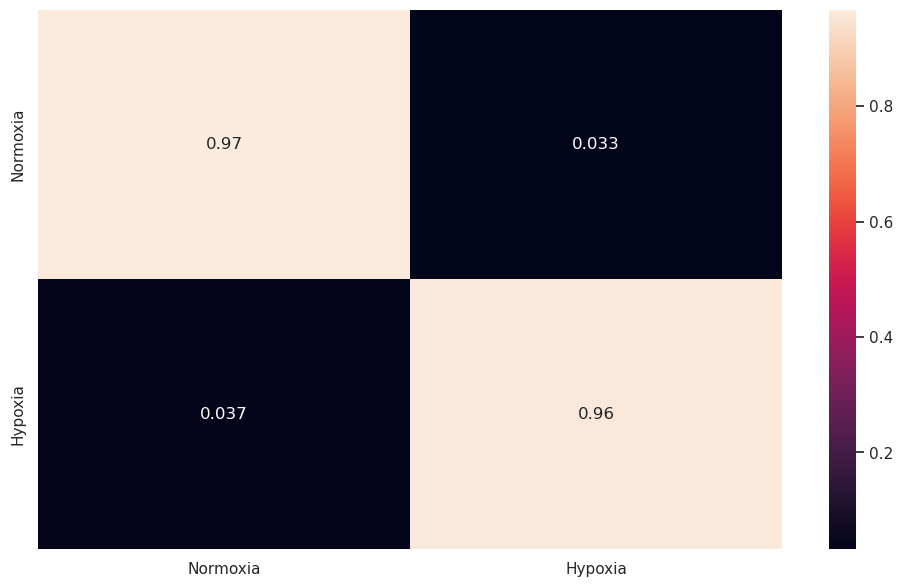

In [ ]:
measure_model(model, merged_data_loader_labeled_smartS_mcf_test)

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

###### KAN (Kolmogorov Arnold Networks)

In [ ]:
model = KANTiny(input_size, 512).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [ ]:
train_config = [
    [1, [10, merged_data_loader_labeled_smartS_mcf_train, merged_data_loader_labeled_smartS_mcf_test, ada, bcelogits]]
]

In [ ]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 3.185873494264872


 10%|█         | 1/10 [00:21<03:13, 21.56s/it]

F1 Score: 0.9623018516051685
Recall: 0.9608938547486033
Accuracy on test: 96.14965986394559%
Epoch 2, Loss: 0.9667729081990926


 20%|██        | 2/10 [00:43<02:53, 21.65s/it]

F1 Score: 0.9687416510820198
Recall: 0.9646182495344506
Accuracy on test: 96.81632653061224%
Epoch 3, Loss: 0.8792724277216779


 30%|███       | 3/10 [01:05<02:32, 21.73s/it]

F1 Score: 0.9700026546323334
Recall: 0.9720670391061452
Accuracy on test: 96.92517006802721%
Epoch 4, Loss: 0.1473688607306584


 40%|████      | 4/10 [01:27<02:11, 21.83s/it]

F1 Score: 0.9720893141945773
Recall: 0.9728651237031125
Accuracy on test: 97.14285714285714%
Epoch 5, Loss: 0.04064513306416895


 50%|█████     | 5/10 [01:49<01:49, 21.88s/it]

F1 Score: 0.970043935561177
Recall: 0.9691407289172652
Accuracy on test: 96.93877551020408%
Epoch 6, Loss: 0.17559861716935815


 60%|██████    | 6/10 [02:11<01:27, 21.92s/it]

F1 Score: 0.9708067940552016
Recall: 0.9731311519021016
Accuracy on test: 97.00680272108843%
Epoch 7, Loss: 0.07679038298437776


 70%|███████   | 7/10 [02:32<01:05, 21.89s/it]

F1 Score: 0.9696727853152434
Recall: 0.9696727853152434
Accuracy on test: 96.89795918367346%
Epoch 8, Loss: 0.05017623059988103


 80%|████████  | 8/10 [02:54<00:43, 21.89s/it]

F1 Score: 0.9715501196490295
Recall: 0.9720670391061452
Accuracy on test: 97.08843537414967%
Epoch 9, Loss: 0.01897750301387809


 90%|█████████ | 9/10 [03:16<00:21, 21.98s/it]

F1 Score: 0.9688912523265089
Recall: 0.9694067571162543
Accuracy on test: 96.81632653061224%
Epoch 10, Loss: 0.21158833774768382


100%|██████████| 10/10 [03:38<00:00, 21.90s/it]

F1 Score: 0.9690694278507899
Recall: 0.9710029263101889
Accuracy on test: 96.82993197278911%


10

F1 Score: 0.9700026546323334
Recall: 0.9720670391061452
Accuracy on test: 96.92517006802721%


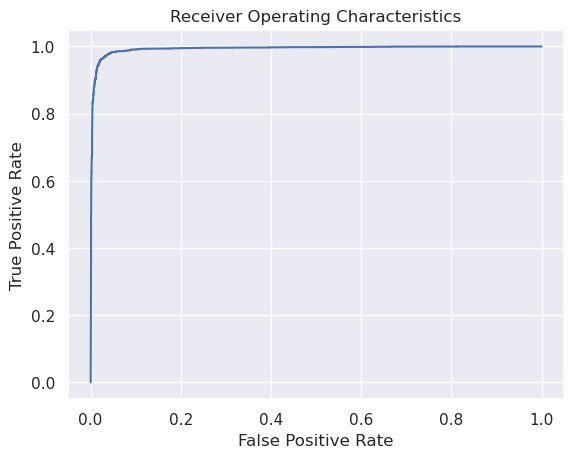

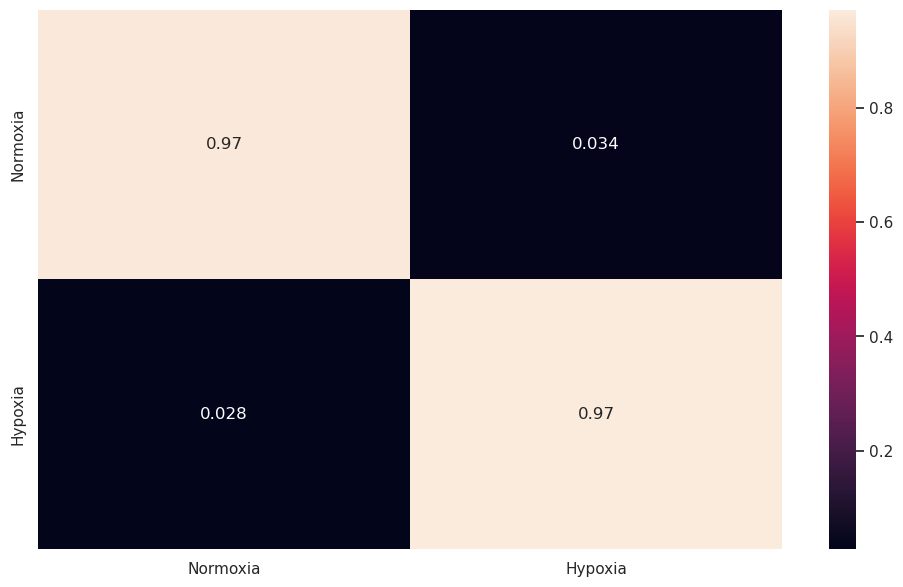

In [ ]:
measure_model(model, merged_data_loader_labeled_smartS_mcf_test)

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

#### Autoencoders

##### Define Models

In [ ]:
class AutoEnc(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(AutoEnc, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.LeakyReLU())
            encoder_layers.append(nn.Dropout(0.5))
            prev_dim = h_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.LeakyReLU())
            decoder_layers.append(nn.Dropout(0.5))
            prev_dim = h_dim
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(hidden_dims[0], input_dim)
        
    def encode(self, x):
        return self.fc_mu(self.encoder(x))
    
    def decode(self, z):
        return self.final_layer(self.decoder(z))
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h

In [ ]:
class MAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(MAE, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim

        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        self.relu = nn.LeakyReLU()
        
    def encode(self, x):
        return self.relu(self.encoder(x))
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h, self.decoder.weight

##### Autoencoders on Individual Data

###### Define Parameters

In [ ]:
input_size = 3000
latent_size = 3

###### Traditional Autoencoders

In [ ]:
models = {}
for name, dataset in data_loaders_train.items():
    model = AutoEnc(input_size, [500], latent_size).to(device)
    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    mseloss = nn.MSELoss()
    train_config = [
        [100, dataset, ada]
    ]
    for segment in train_config:
        num_epochs = segment[0]
        data_loaderr = segment[1]
        optimizer = segment[2]
        epochs = tqdm(range(num_epochs))
        for epoch in epochs:
            running_losses = 0.0
            for inputs, labels in data_loaderr:
                # Zero the parameter gradients
                optimizer.zero_grad()

                recon_batch, mu = model(inputs)
                MSE = mseloss(recon_batch, inputs)

                MSE.backward()
                
                running_losses += MSE.item()

                optimizer.step()

            print(f"Epoch {epoch+1}, Loss: {running_losses/len(data_loaderr)}", flush=True)
    models[name] = model


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 30509138.25


  1%|          | 1/100 [00:00<00:29,  3.33it/s]

Epoch 2, Loss: 1289672.03125
Epoch 3, Loss: 1021880.21875


  3%|▎         | 3/100 [00:00<00:11,  8.51it/s]

Epoch 4, Loss: 775146.296875
Epoch 5, Loss: 829092.921875


  5%|▌         | 5/100 [00:00<00:07, 12.04it/s]

Epoch 6, Loss: 781577.3125
Epoch 7, Loss: 651691.453125
Epoch 8, Loss: 705063.96875


  8%|▊         | 8/100 [00:00<00:06, 15.11it/s]

Epoch 9, Loss: 704801.40625
Epoch 10, Loss: 545590.6484375


 10%|█         | 10/100 [00:00<00:05, 15.83it/s]

Epoch 11, Loss: 560030.28125
Epoch 12, Loss: 548266.8515625


 12%|█▏        | 12/100 [00:00<00:05, 16.59it/s]

Epoch 13, Loss: 589025.21875
Epoch 14, Loss: 614488.578125


 14%|█▍        | 14/100 [00:00<00:04, 17.24it/s]

Epoch 15, Loss: 550847.15625
Epoch 16, Loss: 522366.390625


 16%|█▌        | 16/100 [00:01<00:04, 17.84it/s]

Epoch 17, Loss: 502846.2265625
Epoch 18, Loss: 440273.125


 18%|█▊        | 18/100 [00:01<00:04, 18.20it/s]

Epoch 19, Loss: 541948.5859375
Epoch 20, Loss: 480854.140625


 20%|██        | 20/100 [00:01<00:04, 17.37it/s]

Epoch 21, Loss: 430065.94921875
Epoch 22, Loss: 427443.578125


 22%|██▏       | 22/100 [00:01<00:04, 17.85it/s]

Epoch 23, Loss: 475000.7890625
Epoch 24, Loss: 489955.75


 24%|██▍       | 24/100 [00:01<00:04, 17.75it/s]

Epoch 25, Loss: 458094.109375
Epoch 26, Loss: 420601.8359375


 26%|██▌       | 26/100 [00:01<00:04, 18.09it/s]

Epoch 27, Loss: 455445.171875
Epoch 28, Loss: 413844.609375


 28%|██▊       | 28/100 [00:01<00:03, 18.29it/s]

Epoch 29, Loss: 410762.7578125
Epoch 30, Loss: 391166.3359375


 30%|███       | 30/100 [00:01<00:03, 18.66it/s]

Epoch 31, Loss: 405241.390625
Epoch 32, Loss: 399867.3828125


 32%|███▏      | 32/100 [00:01<00:03, 18.97it/s]

Epoch 33, Loss: 434503.9453125
Epoch 34, Loss: 465188.890625


 34%|███▍      | 34/100 [00:02<00:03, 18.93it/s]

Epoch 35, Loss: 421624.9296875
Epoch 36, Loss: 415402.2421875


 36%|███▌      | 36/100 [00:02<00:03, 18.75it/s]

Epoch 37, Loss: 365157.859375
Epoch 38, Loss: 455557.2109375


 38%|███▊      | 38/100 [00:02<00:03, 18.55it/s]

Epoch 39, Loss: 375296.0859375
Epoch 40, Loss: 362387.2265625


 40%|████      | 40/100 [00:02<00:03, 18.02it/s]

Epoch 41, Loss: 347158.23828125
Epoch 42, Loss: 348923.77734375


 42%|████▏     | 42/100 [00:02<00:03, 18.38it/s]

Epoch 43, Loss: 358910.359375
Epoch 44, Loss: 331112.53515625


 44%|████▍     | 44/100 [00:02<00:02, 18.78it/s]

Epoch 45, Loss: 351758.328125
Epoch 46, Loss: 348880.453125


 46%|████▌     | 46/100 [00:02<00:02, 18.93it/s]

Epoch 47, Loss: 336000.7109375
Epoch 48, Loss: 345499.9921875


 48%|████▊     | 48/100 [00:02<00:02, 18.94it/s]

Epoch 49, Loss: 304267.703125
Epoch 50, Loss: 338954.03125


 50%|█████     | 50/100 [00:02<00:02, 19.11it/s]

Epoch 51, Loss: 330993.8671875
Epoch 52, Loss: 351570.25


 52%|█████▏    | 52/100 [00:03<00:02, 19.31it/s]

Epoch 53, Loss: 418167.984375
Epoch 54, Loss: 372103.84375


 54%|█████▍    | 54/100 [00:03<00:02, 19.44it/s]

Epoch 55, Loss: 355552.90625
Epoch 56, Loss: 303230.62890625


 56%|█████▌    | 56/100 [00:03<00:02, 19.23it/s]

Epoch 57, Loss: 363980.6640625
Epoch 58, Loss: 352287.3984375


 58%|█████▊    | 58/100 [00:03<00:02, 18.01it/s]

Epoch 59, Loss: 294695.9609375
Epoch 60, Loss: 307677.5078125


 60%|██████    | 60/100 [00:03<00:02, 18.04it/s]

Epoch 61, Loss: 287113.93359375
Epoch 62, Loss: 390442.953125


 62%|██████▏   | 62/100 [00:03<00:02, 18.35it/s]

Epoch 63, Loss: 374640.88671875
Epoch 64, Loss: 278540.37890625


 64%|██████▍   | 64/100 [00:03<00:01, 18.71it/s]

Epoch 65, Loss: 335791.2890625
Epoch 66, Loss: 294340.07421875


 66%|██████▌   | 66/100 [00:03<00:01, 18.58it/s]

Epoch 67, Loss: 309546.953125
Epoch 68, Loss: 307251.2578125


 68%|██████▊   | 68/100 [00:03<00:01, 18.79it/s]

Epoch 69, Loss: 327036.95703125
Epoch 70, Loss: 310762.0859375


 70%|███████   | 70/100 [00:03<00:01, 18.87it/s]

Epoch 71, Loss: 296304.37890625
Epoch 72, Loss: 324943.921875


 72%|███████▏  | 72/100 [00:04<00:01, 18.49it/s]

Epoch 73, Loss: 283021.6328125
Epoch 74, Loss: 274265.70703125


 74%|███████▍  | 74/100 [00:04<00:01, 18.69it/s]

Epoch 75, Loss: 304741.90625
Epoch 76, Loss: 283652.23828125


 76%|███████▌  | 76/100 [00:04<00:01, 18.69it/s]

Epoch 77, Loss: 286005.86328125
Epoch 78, Loss: 288123.375


 78%|███████▊  | 78/100 [00:04<00:01, 18.57it/s]

Epoch 79, Loss: 307160.3359375
Epoch 80, Loss: 273117.76953125


 80%|████████  | 80/100 [00:04<00:01, 18.68it/s]

Epoch 81, Loss: 284918.6953125
Epoch 82, Loss: 269402.22265625


 82%|████████▏ | 82/100 [00:04<00:01, 17.91it/s]

Epoch 83, Loss: 295355.78515625
Epoch 84, Loss: 321187.96875


 84%|████████▍ | 84/100 [00:04<00:00, 18.33it/s]

Epoch 85, Loss: 261863.5703125
Epoch 86, Loss: 265320.49609375


 86%|████████▌ | 86/100 [00:04<00:00, 18.46it/s]

Epoch 87, Loss: 278573.09375
Epoch 88, Loss: 269628.6796875


 88%|████████▊ | 88/100 [00:04<00:00, 18.76it/s]

Epoch 89, Loss: 277651.234375
Epoch 90, Loss: 278357.73046875


 90%|█████████ | 90/100 [00:05<00:00, 18.64it/s]

Epoch 91, Loss: 272341.921875
Epoch 92, Loss: 285465.25390625


 92%|█████████▏| 92/100 [00:05<00:00, 18.76it/s]

Epoch 93, Loss: 308585.9375
Epoch 94, Loss: 304058.24609375


 94%|█████████▍| 94/100 [00:05<00:00, 18.95it/s]

Epoch 95, Loss: 255917.40625
Epoch 96, Loss: 310282.0078125


 96%|█████████▌| 96/100 [00:05<00:00, 18.77it/s]

Epoch 97, Loss: 299629.55078125
Epoch 98, Loss: 247619.365234375


 98%|█████████▊| 98/100 [00:05<00:00, 18.81it/s]

Epoch 99, Loss: 277477.25
Epoch 100, Loss: 274818.08203125


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 65398142.916666664
Epoch 2, Loss: 5971665.166666667
Epoch 3, Loss: 991360.4791666666


  3%|▎         | 3/100 [00:00<00:03, 25.16it/s]

Epoch 4, Loss: 983119.9166666666
Epoch 5, Loss: 828067.0833333334
Epoch 6, Loss: 728017.125


  6%|▌         | 6/100 [00:00<00:03, 26.50it/s]

Epoch 7, Loss: 673730.1458333334
Epoch 8, Loss: 625834.5833333334
Epoch 9, Loss: 637923.375


  9%|▉         | 9/100 [00:00<00:03, 26.38it/s]

Epoch 10, Loss: 605755.0208333334
Epoch 11, Loss: 574798.3958333334
Epoch 12, Loss: 560188.6875


 12%|█▏        | 12/100 [00:00<00:03, 26.81it/s]

Epoch 13, Loss: 522755.6666666667
Epoch 14, Loss: 592234.09375
Epoch 15, Loss: 514559.2083333333


 15%|█▌        | 15/100 [00:00<00:03, 27.13it/s]

Epoch 16, Loss: 495275.5833333333
Epoch 17, Loss: 499867.9583333333
Epoch 18, Loss: 505417.0625


 18%|█▊        | 18/100 [00:00<00:03, 27.09it/s]

Epoch 19, Loss: 550897.2291666666
Epoch 20, Loss: 438907.125
Epoch 21, Loss: 456617.125


 21%|██        | 21/100 [00:00<00:03, 26.29it/s]

Epoch 22, Loss: 432853.3229166667
Epoch 23, Loss: 455981.7291666667
Epoch 24, Loss: 421262.9791666667


 24%|██▍       | 24/100 [00:00<00:03, 25.21it/s]

Epoch 25, Loss: 447377.84375
Epoch 26, Loss: 462285.2395833333
Epoch 27, Loss: 452988.1458333333


 27%|██▋       | 27/100 [00:01<00:02, 25.79it/s]

Epoch 28, Loss: 416529.625
Epoch 29, Loss: 408040.03125
Epoch 30, Loss: 397640.4375


 30%|███       | 30/100 [00:01<00:02, 25.93it/s]

Epoch 31, Loss: 385926.40625
Epoch 32, Loss: 414615.4166666667
Epoch 33, Loss: 426564.1979166667


 33%|███▎      | 33/100 [00:01<00:02, 25.96it/s]

Epoch 34, Loss: 383402.4583333333
Epoch 35, Loss: 389425.03125
Epoch 36, Loss: 388243.96875


 36%|███▌      | 36/100 [00:01<00:02, 26.24it/s]

Epoch 37, Loss: 372899.96875
Epoch 38, Loss: 371255.1979166667
Epoch 39, Loss: 384021.40625


 39%|███▉      | 39/100 [00:01<00:02, 25.78it/s]

Epoch 40, Loss: 369610.625
Epoch 41, Loss: 424690.9166666667
Epoch 42, Loss: 379449.8020833333


 42%|████▏     | 42/100 [00:01<00:02, 25.93it/s]

Epoch 43, Loss: 420534.84375
Epoch 44, Loss: 354122.90625
Epoch 45, Loss: 396167.875


 45%|████▌     | 45/100 [00:01<00:02, 26.12it/s]

Epoch 46, Loss: 349727.2604166667
Epoch 47, Loss: 423130.375
Epoch 48, Loss: 329421.6354166667


 48%|████▊     | 48/100 [00:01<00:01, 26.25it/s]

Epoch 49, Loss: 343998.1354166667
Epoch 50, Loss: 396683.8958333333
Epoch 51, Loss: 319194.5520833333


 51%|█████     | 51/100 [00:01<00:01, 25.47it/s]

Epoch 52, Loss: 315282.2239583333
Epoch 53, Loss: 349998.0104166667
Epoch 54, Loss: 353520.8125


 54%|█████▍    | 54/100 [00:02<00:01, 25.74it/s]

Epoch 55, Loss: 321568.4479166667
Epoch 56, Loss: 332285.0208333333
Epoch 57, Loss: 337631.9791666667


 57%|█████▋    | 57/100 [00:02<00:01, 26.24it/s]

Epoch 58, Loss: 347273.6354166667
Epoch 59, Loss: 331545.53125
Epoch 60, Loss: 324438.2395833333


 60%|██████    | 60/100 [00:02<00:01, 26.67it/s]

Epoch 61, Loss: 340906.0729166667
Epoch 62, Loss: 323814.6666666667
Epoch 63, Loss: 292610.3333333333


 63%|██████▎   | 63/100 [00:02<00:01, 26.87it/s]

Epoch 64, Loss: 318525.0208333333
Epoch 65, Loss: 333197.8020833333
Epoch 66, Loss: 318632.7916666667


 66%|██████▌   | 66/100 [00:02<00:01, 27.03it/s]

Epoch 67, Loss: 304809.5572916667
Epoch 68, Loss: 293720.8854166667
Epoch 69, Loss: 308392.8854166667


 69%|██████▉   | 69/100 [00:02<00:01, 27.06it/s]

Epoch 70, Loss: 331423.4270833333
Epoch 71, Loss: 332402.2708333333
Epoch 72, Loss: 343425.0520833333


 72%|███████▏  | 72/100 [00:02<00:01, 27.21it/s]

Epoch 73, Loss: 302346.4166666667
Epoch 74, Loss: 282196.4479166667
Epoch 75, Loss: 295833.3333333333


 75%|███████▌  | 75/100 [00:02<00:00, 26.04it/s]

Epoch 76, Loss: 300483.1458333333
Epoch 77, Loss: 302552.0729166667
Epoch 78, Loss: 298283.0


 78%|███████▊  | 78/100 [00:02<00:00, 26.27it/s]

Epoch 79, Loss: 317989.0520833333
Epoch 80, Loss: 276812.8489583333
Epoch 81, Loss: 290399.8385416667


 81%|████████  | 81/100 [00:03<00:00, 26.30it/s]

Epoch 82, Loss: 336025.53125
Epoch 83, Loss: 313992.3958333333
Epoch 84, Loss: 301385.8177083333


 84%|████████▍ | 84/100 [00:03<00:00, 26.79it/s]

Epoch 85, Loss: 274104.6614583333
Epoch 86, Loss: 323411.1354166667
Epoch 87, Loss: 273185.0885416667


 87%|████████▋ | 87/100 [00:03<00:00, 27.00it/s]

Epoch 88, Loss: 275863.125
Epoch 89, Loss: 321639.6302083333
Epoch 90, Loss: 307261.34375


 90%|█████████ | 90/100 [00:03<00:00, 27.03it/s]

Epoch 91, Loss: 306697.53125
Epoch 92, Loss: 325962.4791666667
Epoch 93, Loss: 281332.4739583333


 93%|█████████▎| 93/100 [00:03<00:00, 26.93it/s]

Epoch 94, Loss: 319300.90625
Epoch 95, Loss: 329367.4739583333
Epoch 96, Loss: 269688.3020833333


 96%|█████████▌| 96/100 [00:03<00:00, 27.07it/s]

Epoch 97, Loss: 272966.515625
Epoch 98, Loss: 311903.2864583333
Epoch 99, Loss: 279213.0104166667


 99%|█████████▉| 99/100 [00:03<00:00, 26.99it/s]

Epoch 100, Loss: 276322.1197916667


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.07393470803804943


  1%|          | 1/100 [00:04<07:15,  4.40s/it]

Epoch 2, Loss: 0.05300481720549154


  2%|▏         | 2/100 [00:08<07:08,  4.38s/it]

Epoch 3, Loss: 0.04843467660935603


  3%|▎         | 3/100 [00:13<07:03,  4.37s/it]

Epoch 4, Loss: 0.046168599373959965


  4%|▍         | 4/100 [00:17<07:00,  4.38s/it]

Epoch 5, Loss: 0.04530278431093561


  5%|▌         | 5/100 [00:21<06:56,  4.38s/it]

Epoch 6, Loss: 0.04450903749059047


  6%|▌         | 6/100 [00:26<06:53,  4.39s/it]

Epoch 7, Loss: 0.0440562614875526


  7%|▋         | 7/100 [00:30<06:49,  4.41s/it]

Epoch 8, Loss: 0.04369833299759569


  8%|▊         | 8/100 [00:35<06:48,  4.45s/it]

Epoch 9, Loss: 0.04338178111453338


  9%|▉         | 9/100 [00:39<06:45,  4.46s/it]

Epoch 10, Loss: 0.043215639188170875


 10%|█         | 10/100 [00:44<06:41,  4.46s/it]

Epoch 11, Loss: 0.043085022014995346


 11%|█         | 11/100 [00:48<06:37,  4.46s/it]

Epoch 12, Loss: 0.04284483323567908


 12%|█▏        | 12/100 [00:53<06:35,  4.49s/it]

Epoch 13, Loss: 0.042798732094659134


 13%|█▎        | 13/100 [00:57<06:30,  4.49s/it]

Epoch 14, Loss: 0.042645081066667374


 14%|█▍        | 14/100 [01:02<06:25,  4.48s/it]

Epoch 15, Loss: 0.04260219250053057


 15%|█▌        | 15/100 [01:06<06:20,  4.48s/it]

Epoch 16, Loss: 0.042336208092880426


 16%|█▌        | 16/100 [01:11<06:15,  4.47s/it]

Epoch 17, Loss: 0.04231625547928124


 17%|█▋        | 17/100 [01:15<06:11,  4.48s/it]

Epoch 18, Loss: 0.042229196902130804


 18%|█▊        | 18/100 [01:20<06:06,  4.48s/it]

Epoch 19, Loss: 0.042265426188817325


 19%|█▉        | 19/100 [01:24<06:03,  4.48s/it]

Epoch 20, Loss: 0.04205365265922353


 20%|██        | 20/100 [01:29<05:58,  4.48s/it]

Epoch 21, Loss: 0.04199377707174783


 21%|██        | 21/100 [01:33<05:53,  4.48s/it]

Epoch 22, Loss: 0.04202682458936508


 22%|██▏       | 22/100 [01:38<05:50,  4.49s/it]

Epoch 23, Loss: 0.04188350047847442


 23%|██▎       | 23/100 [01:42<05:46,  4.49s/it]

Epoch 24, Loss: 0.04179828075135326


 24%|██▍       | 24/100 [01:47<05:41,  4.50s/it]

Epoch 25, Loss: 0.04174058768911995


 25%|██▌       | 25/100 [01:51<05:37,  4.50s/it]

Epoch 26, Loss: 0.041712848861389054


 26%|██▌       | 26/100 [01:56<05:33,  4.50s/it]

Epoch 27, Loss: 0.04174233023145982


 27%|██▋       | 27/100 [02:00<05:29,  4.52s/it]

Epoch 28, Loss: 0.04165471115620374


 28%|██▊       | 28/100 [02:05<05:25,  4.52s/it]

Epoch 29, Loss: 0.04164567199360401


 29%|██▉       | 29/100 [02:09<05:20,  4.52s/it]

Epoch 30, Loss: 0.041619330259706704


 30%|███       | 30/100 [02:14<05:16,  4.52s/it]

Epoch 31, Loss: 0.04157581482756182


 31%|███       | 31/100 [02:18<05:12,  4.52s/it]

Epoch 32, Loss: 0.0415303139668989


 32%|███▏      | 32/100 [02:23<05:07,  4.52s/it]

Epoch 33, Loss: 0.041449577193638495


 33%|███▎      | 33/100 [02:27<05:03,  4.53s/it]

Epoch 34, Loss: 0.041411331920056325


 34%|███▍      | 34/100 [02:32<04:59,  4.53s/it]

Epoch 35, Loss: 0.041387302038084536


 35%|███▌      | 35/100 [02:36<04:54,  4.53s/it]

Epoch 36, Loss: 0.04135786493161068


 36%|███▌      | 36/100 [02:41<04:49,  4.53s/it]

Epoch 37, Loss: 0.041325321070492485


 37%|███▋      | 37/100 [02:45<04:45,  4.53s/it]

Epoch 38, Loss: 0.0413390003502149


 38%|███▊      | 38/100 [02:50<04:41,  4.53s/it]

Epoch 39, Loss: 0.04129951312533164


 39%|███▉      | 39/100 [02:54<04:36,  4.53s/it]

Epoch 40, Loss: 0.041285599179813344


 40%|████      | 40/100 [02:59<04:32,  4.54s/it]

Epoch 41, Loss: 0.04128847920036844


 41%|████      | 41/100 [03:04<04:27,  4.54s/it]

Epoch 42, Loss: 0.041278385615656735


 42%|████▏     | 42/100 [03:08<04:23,  4.54s/it]

Epoch 43, Loss: 0.04130264041718522


 43%|████▎     | 43/100 [03:13<04:18,  4.54s/it]

Epoch 44, Loss: 0.04123098278122635


 44%|████▍     | 44/100 [03:17<04:13,  4.53s/it]

Epoch 45, Loss: 0.0412272690242067


 45%|████▌     | 45/100 [03:22<04:09,  4.54s/it]

Epoch 46, Loss: 0.04115044288474695


 46%|████▌     | 46/100 [03:26<04:05,  4.54s/it]

Epoch 47, Loss: 0.041140374016167935


 47%|████▋     | 47/100 [03:31<04:00,  4.54s/it]

Epoch 48, Loss: 0.04106605168418251


 48%|████▊     | 48/100 [03:35<03:56,  4.55s/it]

Epoch 49, Loss: 0.04106070517778836


 49%|████▉     | 49/100 [03:40<03:51,  4.55s/it]

Epoch 50, Loss: 0.04109064117074013


 50%|█████     | 50/100 [03:44<03:47,  4.55s/it]

Epoch 51, Loss: 0.04108403832050267


 51%|█████     | 51/100 [03:49<03:42,  4.55s/it]

Epoch 52, Loss: 0.04112168543068245


 52%|█████▏    | 52/100 [03:54<03:38,  4.55s/it]

Epoch 53, Loss: 0.041068467679278874


 53%|█████▎    | 53/100 [03:58<03:33,  4.54s/it]

Epoch 54, Loss: 0.04105486858264987


 54%|█████▍    | 54/100 [04:03<03:29,  4.54s/it]

Epoch 55, Loss: 0.041087069607088925


 55%|█████▌    | 55/100 [04:07<03:24,  4.54s/it]

Epoch 56, Loss: 0.04103227231885234


 56%|█████▌    | 56/100 [04:12<03:20,  4.55s/it]

Epoch 57, Loss: 0.04101377622502756


 57%|█████▋    | 57/100 [04:16<03:15,  4.55s/it]

Epoch 58, Loss: 0.041014311140973626


 58%|█████▊    | 58/100 [04:21<03:10,  4.54s/it]

Epoch 59, Loss: 0.04099431045600849


 59%|█████▉    | 59/100 [04:25<03:06,  4.56s/it]

Epoch 60, Loss: 0.04096835532751471


 60%|██████    | 60/100 [04:30<03:02,  4.55s/it]

Epoch 61, Loss: 0.04096883428162754


 61%|██████    | 61/100 [04:35<02:57,  4.55s/it]

Epoch 62, Loss: 0.04101194257115966


 62%|██████▏   | 62/100 [04:39<02:52,  4.55s/it]

Epoch 63, Loss: 0.04093478452345542


 63%|██████▎   | 63/100 [04:44<02:48,  4.55s/it]

Epoch 64, Loss: 0.040923326740185714


 64%|██████▍   | 64/100 [04:48<02:43,  4.54s/it]

Epoch 65, Loss: 0.04094439509884898


 65%|██████▌   | 65/100 [04:53<02:38,  4.54s/it]

Epoch 66, Loss: 0.04097434529189254


 66%|██████▌   | 66/100 [04:57<02:34,  4.55s/it]

Epoch 67, Loss: 0.04088636841006384


 67%|██████▋   | 67/100 [05:02<02:29,  4.54s/it]

Epoch 68, Loss: 0.040946523696734016


 68%|██████▊   | 68/100 [05:06<02:25,  4.54s/it]

Epoch 69, Loss: 0.04089985390595844


 69%|██████▉   | 69/100 [05:11<02:20,  4.54s/it]

Epoch 70, Loss: 0.04089248496557953


 70%|███████   | 70/100 [05:15<02:16,  4.54s/it]

Epoch 71, Loss: 0.04088289095466867


 71%|███████   | 71/100 [05:20<02:11,  4.55s/it]

Epoch 72, Loss: 0.04091281225265612


 72%|███████▏  | 72/100 [05:24<02:07,  4.55s/it]

Epoch 73, Loss: 0.04084034185732863


 73%|███████▎  | 73/100 [05:29<02:02,  4.55s/it]

Epoch 74, Loss: 0.04085768221764107


 74%|███████▍  | 74/100 [05:34<01:58,  4.55s/it]

Epoch 75, Loss: 0.04088517290804659


 75%|███████▌  | 75/100 [05:38<01:53,  4.55s/it]

Epoch 76, Loss: 0.04080348621325299


 76%|███████▌  | 76/100 [05:43<01:49,  4.55s/it]

Epoch 77, Loss: 0.04085217243081089


 77%|███████▋  | 77/100 [05:47<01:44,  4.55s/it]

Epoch 78, Loss: 0.04081473183367965


 78%|███████▊  | 78/100 [05:52<01:40,  4.56s/it]

Epoch 79, Loss: 0.04081341117015624


 79%|███████▉  | 79/100 [05:56<01:35,  4.56s/it]

Epoch 80, Loss: 0.040819226980649236


 80%|████████  | 80/100 [06:01<01:31,  4.59s/it]

Epoch 81, Loss: 0.04074739246900671


 81%|████████  | 81/100 [06:06<01:27,  4.59s/it]

Epoch 82, Loss: 0.040830044261423865


 82%|████████▏ | 82/100 [06:10<01:22,  4.59s/it]

Epoch 83, Loss: 0.04079278449895637


 83%|████████▎ | 83/100 [06:15<01:18,  4.59s/it]

Epoch 84, Loss: 0.040867886557570246


 84%|████████▍ | 84/100 [06:19<01:13,  4.58s/it]

Epoch 85, Loss: 0.040777183038172245


 85%|████████▌ | 85/100 [06:24<01:08,  4.58s/it]

Epoch 86, Loss: 0.04076291230331928


 86%|████████▌ | 86/100 [06:29<01:03,  4.57s/it]

Epoch 87, Loss: 0.04077582846213531


 87%|████████▋ | 87/100 [06:33<00:59,  4.57s/it]

Epoch 88, Loss: 0.04081316077841164


 88%|████████▊ | 88/100 [06:38<00:54,  4.56s/it]

Epoch 89, Loss: 0.04073011701947209


 89%|████████▉ | 89/100 [06:42<00:50,  4.56s/it]

Epoch 90, Loss: 0.04072748161714895


 90%|█████████ | 90/100 [06:47<00:45,  4.56s/it]

Epoch 91, Loss: 0.04075107257469554


 91%|█████████ | 91/100 [06:51<00:41,  4.57s/it]

Epoch 92, Loss: 0.040727949904009866


 92%|█████████▏| 92/100 [06:56<00:36,  4.56s/it]

Epoch 93, Loss: 0.04074002971453421


 93%|█████████▎| 93/100 [07:00<00:31,  4.56s/it]

Epoch 94, Loss: 0.040738042650187586


 94%|█████████▍| 94/100 [07:05<00:27,  4.55s/it]

Epoch 95, Loss: 0.040744337016146125


 95%|█████████▌| 95/100 [07:10<00:22,  4.56s/it]

Epoch 96, Loss: 0.04064520170767809


 96%|█████████▌| 96/100 [07:14<00:18,  4.56s/it]

Epoch 97, Loss: 0.04083749216146135


 97%|█████████▋| 97/100 [07:19<00:13,  4.56s/it]

Epoch 98, Loss: 0.04069424219896873


 98%|█████████▊| 98/100 [07:23<00:09,  4.57s/it]

Epoch 99, Loss: 0.04068302288926395


 99%|█████████▉| 99/100 [07:28<00:04,  4.56s/it]

Epoch 100, Loss: 0.04069703451711753


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 0.07797478619234069


  1%|          | 1/100 [00:02<04:49,  2.92s/it]

Epoch 2, Loss: 0.056960335871933596


  2%|▏         | 2/100 [00:05<04:46,  2.92s/it]

Epoch 3, Loss: 0.05380380906812523


  3%|▎         | 3/100 [00:08<04:43,  2.92s/it]

Epoch 4, Loss: 0.05191956885644923


  4%|▍         | 4/100 [00:11<04:40,  2.92s/it]

Epoch 5, Loss: 0.050801981665679945


  5%|▌         | 5/100 [00:14<04:37,  2.92s/it]

Epoch 6, Loss: 0.05008563476250223


  6%|▌         | 6/100 [00:17<04:35,  2.93s/it]

Epoch 7, Loss: 0.0495592767737158


  7%|▋         | 7/100 [00:20<04:33,  2.94s/it]

Epoch 8, Loss: 0.049158285797128214


  8%|▊         | 8/100 [00:23<04:32,  2.96s/it]

Epoch 9, Loss: 0.04879247223067543


  9%|▉         | 9/100 [00:26<04:29,  2.96s/it]

Epoch 10, Loss: 0.04853776868675714


 10%|█         | 10/100 [00:29<04:24,  2.94s/it]

Epoch 11, Loss: 0.048342232511419315


 11%|█         | 11/100 [00:32<04:21,  2.94s/it]

Epoch 12, Loss: 0.048101984733796635


 12%|█▏        | 12/100 [00:35<04:19,  2.95s/it]

Epoch 13, Loss: 0.0479418166467677


 13%|█▎        | 13/100 [00:38<04:16,  2.95s/it]

Epoch 14, Loss: 0.04774843840657369


 14%|█▍        | 14/100 [00:41<04:13,  2.95s/it]

Epoch 15, Loss: 0.047722239047288895


 15%|█▌        | 15/100 [00:44<04:09,  2.94s/it]

Epoch 16, Loss: 0.04761032413934236


 16%|█▌        | 16/100 [00:47<04:06,  2.94s/it]

Epoch 17, Loss: 0.04749648125194337


 17%|█▋        | 17/100 [00:49<04:03,  2.94s/it]

Epoch 18, Loss: 0.04741390693284895


 18%|█▊        | 18/100 [00:52<04:01,  2.94s/it]

Epoch 19, Loss: 0.047315941009994436


 19%|█▉        | 19/100 [00:55<03:58,  2.94s/it]

Epoch 20, Loss: 0.04721365769839157


 20%|██        | 20/100 [00:58<03:55,  2.94s/it]

Epoch 21, Loss: 0.0471750292117181


 21%|██        | 21/100 [01:01<03:51,  2.93s/it]

Epoch 22, Loss: 0.047049411167593105


 22%|██▏       | 22/100 [01:04<03:49,  2.94s/it]

Epoch 23, Loss: 0.04698966617655495


 23%|██▎       | 23/100 [01:07<03:46,  2.94s/it]

Epoch 24, Loss: 0.04696951466410056


 24%|██▍       | 24/100 [01:10<03:42,  2.93s/it]

Epoch 25, Loss: 0.046937735366594534


 25%|██▌       | 25/100 [01:13<03:39,  2.93s/it]

Epoch 26, Loss: 0.04689285037634165


 26%|██▌       | 26/100 [01:16<03:37,  2.94s/it]

Epoch 27, Loss: 0.046814963282288416


 27%|██▋       | 27/100 [01:19<03:36,  2.97s/it]

Epoch 28, Loss: 0.046798454941776785


 28%|██▊       | 28/100 [01:22<03:34,  2.97s/it]

Epoch 29, Loss: 0.04670402302366236


 29%|██▉       | 29/100 [01:25<03:31,  2.98s/it]

Epoch 30, Loss: 0.046718192448758564


 30%|███       | 30/100 [01:28<03:28,  2.98s/it]

Epoch 31, Loss: 0.0466746818476721


 31%|███       | 31/100 [01:31<03:24,  2.97s/it]

Epoch 32, Loss: 0.04666852345690131


 32%|███▏      | 32/100 [01:34<03:20,  2.95s/it]

Epoch 33, Loss: 0.04658596288493794


 33%|███▎      | 33/100 [01:37<03:17,  2.94s/it]

Epoch 34, Loss: 0.046525964634897915


 34%|███▍      | 34/100 [01:40<03:13,  2.94s/it]

Epoch 35, Loss: 0.04649446718394756


 35%|███▌      | 35/100 [01:43<03:10,  2.94s/it]

Epoch 36, Loss: 0.04645327403736503


 36%|███▌      | 36/100 [01:46<03:08,  2.95s/it]

Epoch 37, Loss: 0.04644229917017662


 37%|███▋      | 37/100 [01:48<03:06,  2.95s/it]

Epoch 38, Loss: 0.046400643702920366


 38%|███▊      | 38/100 [01:52<03:05,  2.99s/it]

Epoch 39, Loss: 0.04633360769113769


 39%|███▉      | 39/100 [01:55<03:03,  3.00s/it]

Epoch 40, Loss: 0.04635641031453143


 40%|████      | 40/100 [01:58<03:00,  3.01s/it]

Epoch 41, Loss: 0.04634663740011013


 41%|████      | 41/100 [02:01<02:57,  3.01s/it]

Epoch 42, Loss: 0.046280435185231596


 42%|████▏     | 42/100 [02:04<02:55,  3.02s/it]

Epoch 43, Loss: 0.04628164794943903


 43%|████▎     | 43/100 [02:07<02:52,  3.04s/it]

Epoch 44, Loss: 0.046215979888549315


 44%|████▍     | 44/100 [02:10<02:49,  3.03s/it]

Epoch 45, Loss: 0.04624445262648489


 45%|████▌     | 45/100 [02:13<02:45,  3.02s/it]

Epoch 46, Loss: 0.046183604726810816


 46%|████▌     | 46/100 [02:16<02:42,  3.00s/it]

Epoch 47, Loss: 0.046215351266057594


 47%|████▋     | 47/100 [02:19<02:38,  2.99s/it]

Epoch 48, Loss: 0.04613314595316415


 48%|████▊     | 48/100 [02:22<02:34,  2.98s/it]

Epoch 49, Loss: 0.0461228622690491


 49%|████▉     | 49/100 [02:25<02:31,  2.97s/it]

Epoch 50, Loss: 0.04610908484977225


 50%|█████     | 50/100 [02:27<02:27,  2.96s/it]

Epoch 51, Loss: 0.046102507546058165


 51%|█████     | 51/100 [02:30<02:24,  2.96s/it]

Epoch 52, Loss: 0.04611738977710838


 52%|█████▏    | 52/100 [02:33<02:21,  2.95s/it]

Epoch 53, Loss: 0.04606066800087043


 53%|█████▎    | 53/100 [02:36<02:18,  2.95s/it]

Epoch 54, Loss: 0.04605133679654935


 54%|█████▍    | 54/100 [02:39<02:15,  2.96s/it]

Epoch 55, Loss: 0.04603546323335689


 55%|█████▌    | 55/100 [02:42<02:12,  2.95s/it]

Epoch 56, Loss: 0.0460200140900586


 56%|█████▌    | 56/100 [02:45<02:09,  2.94s/it]

Epoch 57, Loss: 0.046041563214005335


 57%|█████▋    | 57/100 [02:48<02:06,  2.93s/it]

Epoch 58, Loss: 0.046044824320984924


 58%|█████▊    | 58/100 [02:51<02:03,  2.93s/it]

Epoch 59, Loss: 0.0459421224406232


 59%|█████▉    | 59/100 [02:54<02:00,  2.93s/it]

Epoch 60, Loss: 0.04591656306191631


 60%|██████    | 60/100 [02:57<01:57,  2.93s/it]

Epoch 61, Loss: 0.045960475467955286


 61%|██████    | 61/100 [03:00<01:53,  2.92s/it]

Epoch 62, Loss: 0.045952948701122535


 62%|██████▏   | 62/100 [03:03<01:50,  2.92s/it]

Epoch 63, Loss: 0.045906953108699425


 63%|██████▎   | 63/100 [03:06<01:47,  2.91s/it]

Epoch 64, Loss: 0.045908341265243034


 64%|██████▍   | 64/100 [03:08<01:44,  2.90s/it]

Epoch 65, Loss: 0.04593304058779841


 65%|██████▌   | 65/100 [03:11<01:41,  2.89s/it]

Epoch 66, Loss: 0.04585276266721928


 66%|██████▌   | 66/100 [03:14<01:38,  2.89s/it]

Epoch 67, Loss: 0.04583491905308936


 67%|██████▋   | 67/100 [03:17<01:35,  2.89s/it]

Epoch 68, Loss: 0.045918252035651516


 68%|██████▊   | 68/100 [03:20<01:32,  2.88s/it]

Epoch 69, Loss: 0.04584756311353134


 69%|██████▉   | 69/100 [03:23<01:29,  2.88s/it]

Epoch 70, Loss: 0.045816746641598315


 70%|███████   | 70/100 [03:26<01:26,  2.89s/it]

Epoch 71, Loss: 0.04584624508962683


 71%|███████   | 71/100 [03:29<01:23,  2.88s/it]

Epoch 72, Loss: 0.045863274444380535


 72%|███████▏  | 72/100 [03:31<01:20,  2.88s/it]

Epoch 73, Loss: 0.04578637746770097


 73%|███████▎  | 73/100 [03:34<01:17,  2.88s/it]

Epoch 74, Loss: 0.04585088133488013


 74%|███████▍  | 74/100 [03:37<01:15,  2.88s/it]

Epoch 75, Loss: 0.04581481878362272


 75%|███████▌  | 75/100 [03:40<01:11,  2.88s/it]

Epoch 76, Loss: 0.0457519532950676


 76%|███████▌  | 76/100 [03:43<01:09,  2.88s/it]

Epoch 77, Loss: 0.045799158351576844


 77%|███████▋  | 77/100 [03:46<01:05,  2.87s/it]

Epoch 78, Loss: 0.045747206202181784


 78%|███████▊  | 78/100 [03:49<01:03,  2.87s/it]

Epoch 79, Loss: 0.04578515249506935


 79%|███████▉  | 79/100 [03:52<01:00,  2.87s/it]

Epoch 80, Loss: 0.04576432075270492


 80%|████████  | 80/100 [03:54<00:57,  2.87s/it]

Epoch 81, Loss: 0.04572027099683233


 81%|████████  | 81/100 [03:57<00:54,  2.88s/it]

Epoch 82, Loss: 0.04575253826687518


 82%|████████▏ | 82/100 [04:00<00:51,  2.87s/it]

Epoch 83, Loss: 0.045791206071558205


 83%|████████▎ | 83/100 [04:03<00:48,  2.88s/it]

Epoch 84, Loss: 0.04573171027004719


 84%|████████▍ | 84/100 [04:06<00:46,  2.88s/it]

Epoch 85, Loss: 0.045686111198333296


 85%|████████▌ | 85/100 [04:09<00:43,  2.87s/it]

Epoch 86, Loss: 0.04573403509414714


 86%|████████▌ | 86/100 [04:12<00:40,  2.88s/it]

Epoch 87, Loss: 0.04570157589066936


 87%|████████▋ | 87/100 [04:15<00:37,  2.87s/it]

Epoch 88, Loss: 0.04569770715644826


 88%|████████▊ | 88/100 [04:17<00:34,  2.88s/it]

Epoch 89, Loss: 0.04567522290365204


 89%|████████▉ | 89/100 [04:20<00:31,  2.87s/it]

Epoch 90, Loss: 0.045687698010031294


 90%|█████████ | 90/100 [04:23<00:28,  2.88s/it]

Epoch 91, Loss: 0.04567694028272577


 91%|█████████ | 91/100 [04:26<00:25,  2.88s/it]

Epoch 92, Loss: 0.045688243380383305


 92%|█████████▏| 92/100 [04:29<00:22,  2.87s/it]

Epoch 93, Loss: 0.045641229305740286


 93%|█████████▎| 93/100 [04:32<00:20,  2.88s/it]

Epoch 94, Loss: 0.04563265071129021


 94%|█████████▍| 94/100 [04:35<00:17,  2.88s/it]

Epoch 95, Loss: 0.045669434004989656


 95%|█████████▌| 95/100 [04:38<00:14,  2.88s/it]

Epoch 96, Loss: 0.0456768953970269


 96%|█████████▌| 96/100 [04:41<00:11,  2.88s/it]

Epoch 97, Loss: 0.045630066270899515


 97%|█████████▋| 97/100 [04:43<00:08,  2.87s/it]

Epoch 98, Loss: 0.04568652434112585


 98%|█████████▊| 98/100 [04:46<00:05,  2.88s/it]

Epoch 99, Loss: 0.0455986434067397


 99%|█████████▉| 99/100 [04:49<00:02,  2.87s/it]

Epoch 100, Loss: 0.045604594294791634


100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


In [ ]:
for name, model in models.items():
    outputs = []
    cell_labels = []
    with torch.no_grad():
        for inputs, labels in data_loaders_test[name]:
            recon_batch, mu = model(inputs)
            outputs.extend(mu.cpu().numpy())
            cell_labels.extend(labels.cpu().numpy())

    pred_df = pd.DataFrame(outputs)
    pred_df["Condition"] = cell_labels
    fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
    fig.show()

In [ ]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

##### Autoencoders on Grouped Data

###### Define Parameters

In [ ]:
input_size = merged_train_dataset.shape[1]
latent_size = 3

###### Traditional Autoencoders

In [ ]:
# Initialize Model
model = AutoEnc(input_size, [1000, 200], latent_size).to(device)

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [ ]:
# Loss Functions
mseloss = nn.MSELoss()

In [ ]:
# Train
train_config = [
    [100, merged_data_loader_train, ada]
]

In [ ]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        running_losses = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, mu = model(inputs)
            MSE = mseloss(recon_batch, inputs)

            MSE.backward()
            
            running_losses += MSE.item()

            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {running_losses/len(data_loaderr)}", flush=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1, Loss: 1368.7264588670562


  0%|          | 1/5000 [00:10<14:07:43, 10.17s/it]

Epoch 2, Loss: 1348.0165771552079


  0%|          | 2/5000 [00:20<14:09:45, 10.20s/it]

Epoch 3, Loss: 1293.8766095431279


  0%|          | 3/5000 [00:30<14:09:53, 10.20s/it]

Epoch 4, Loss: 1337.4392357223708


  0%|          | 4/5000 [00:40<14:05:59, 10.16s/it]

Epoch 5, Loss: 1300.1233285252815


  0%|          | 5/5000 [00:50<14:06:37, 10.17s/it]

Epoch 6, Loss: 1357.2955875137577


  0%|          | 6/5000 [01:01<14:07:51, 10.19s/it]

Epoch 7, Loss: 1247.8278382320443


  0%|          | 7/5000 [01:11<14:07:22, 10.18s/it]

Epoch 8, Loss: 1255.3493105017944


  0%|          | 8/5000 [01:21<14:07:35, 10.19s/it]

Epoch 9, Loss: 1250.578113699575


  0%|          | 9/5000 [01:31<14:08:11, 10.20s/it]

Epoch 10, Loss: 1252.0015845208065


  0%|          | 10/5000 [01:41<14:07:46, 10.19s/it]

Epoch 11, Loss: 1214.8118850004737


  0%|          | 11/5000 [01:51<14:03:17, 10.14s/it]

Epoch 12, Loss: 1222.943156302623


  0%|          | 12/5000 [02:01<13:56:40, 10.06s/it]

Epoch 13, Loss: 1268.902531412762


  0%|          | 13/5000 [02:11<13:50:23,  9.99s/it]

Epoch 14, Loss: 1205.7384173568823


  0%|          | 14/5000 [02:21<13:47:02,  9.95s/it]

Epoch 15, Loss: 1243.974022490272


  0%|          | 15/5000 [02:31<13:43:07,  9.91s/it]

Epoch 16, Loss: 1207.4856529887604


  0%|          | 16/5000 [02:41<13:41:02,  9.88s/it]

Epoch 17, Loss: 1297.5062545564188


  0%|          | 17/5000 [02:50<13:37:48,  9.85s/it]

Epoch 18, Loss: 1204.4802670139982


  0%|          | 18/5000 [03:00<13:37:31,  9.85s/it]

Epoch 19, Loss: 1234.6869547662852


  0%|          | 19/5000 [03:10<13:36:49,  9.84s/it]

Epoch 20, Loss: 1199.8454642719873


  0%|          | 20/5000 [03:20<13:35:59,  9.83s/it]

Epoch 21, Loss: 1203.1846057406585


  0%|          | 21/5000 [03:30<13:36:16,  9.84s/it]

Epoch 22, Loss: 1163.6066495866555


  0%|          | 22/5000 [03:39<13:34:22,  9.82s/it]

Epoch 23, Loss: 1214.810355804569


  0%|          | 23/5000 [03:49<13:34:50,  9.82s/it]

Epoch 24, Loss: 1202.2852585665235


  0%|          | 24/5000 [03:59<13:33:42,  9.81s/it]

Epoch 25, Loss: 1218.1985620214887


  0%|          | 25/5000 [04:09<13:33:31,  9.81s/it]

Epoch 26, Loss: 1200.9202449321747


  1%|          | 26/5000 [04:19<13:33:02,  9.81s/it]

Epoch 27, Loss: 1189.2050630181704


  1%|          | 27/5000 [04:29<13:32:53,  9.81s/it]

Epoch 28, Loss: 1181.5118291690621


  1%|          | 28/5000 [04:38<13:33:04,  9.81s/it]

Epoch 29, Loss: 1165.04001088719


  1%|          | 29/5000 [04:48<13:30:53,  9.79s/it]

Epoch 30, Loss: 1157.8802640313363


  1%|          | 30/5000 [04:58<13:31:39,  9.80s/it]

Epoch 31, Loss: 1174.6510185335965


  1%|          | 31/5000 [05:08<13:30:51,  9.79s/it]

Epoch 32, Loss: 1160.2514068900891


  1%|          | 32/5000 [05:17<13:31:44,  9.80s/it]

Epoch 33, Loss: 1152.995903603927


  1%|          | 33/5000 [05:27<13:30:41,  9.79s/it]

Epoch 34, Loss: 1154.2732562281515


  1%|          | 34/5000 [05:37<13:30:30,  9.79s/it]

Epoch 35, Loss: 1161.2199201472426


  1%|          | 35/5000 [05:47<13:28:22,  9.77s/it]

Epoch 36, Loss: 1134.7479313722447


  1%|          | 36/5000 [05:57<13:29:55,  9.79s/it]

Epoch 37, Loss: 1115.6571872967093


  1%|          | 37/5000 [06:06<13:30:04,  9.79s/it]

Epoch 38, Loss: 1138.9811025171823


  1%|          | 38/5000 [06:16<13:30:34,  9.80s/it]

Epoch 39, Loss: 1125.3394919636132


  1%|          | 39/5000 [06:26<13:29:44,  9.79s/it]

Epoch 40, Loss: 1156.2895105315615


  1%|          | 40/5000 [06:36<13:29:03,  9.79s/it]

Epoch 41, Loss: 1140.731275008619


  1%|          | 41/5000 [06:46<13:28:38,  9.78s/it]

Epoch 42, Loss: 1132.4572651982955


  1%|          | 42/5000 [07:00<13:47:23, 10.01s/it]


KeyboardInterrupt: 

In [ ]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        recon_batch, mu = model(inputs)
        outputs.extend(nn.Sigmoid()(mu).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [ ]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

###### Guided Autoencoder

In [ ]:
# Initialize Model
model = AutoEnc(input_size, [2048, 1024], latent_size).to(device)

lr_ada = 1e-2
adm = optim.Adagrad(model.parameters(), lr=lr_ada)

In [ ]:
# Loss Functions
mseloss = nn.MSELoss()

def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

In [ ]:
# Train
train_config = [
    [100, merged_data_loader_train, adm]
]

In [ ]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        running_losses = np.array([0.0,0.0, 0.0])
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, mu = model(inputs)
            MSE = mseloss(recon_batch, inputs)

            latentMSE = bceloss(mu[:, 2], labels)

            MSE.backward(retain_graph=True)
            latentMSE.backward()
            

            running_losses[0] += MSE.item()
            running_losses[1] += latentMSE.item()

            nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loaderr)}: {running_losses/len(data_loaderr)}", flush=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 5359057.186567077: [5.35905586e+06 1.32511395e+00 0.00000000e+00]


  1%|          | 1/100 [00:13<21:34, 13.07s/it]

Epoch 2, Loss: 2304.136637808698: [2.30330277e+03 8.33869253e-01 0.00000000e+00]


  2%|▏         | 2/100 [00:26<21:21, 13.08s/it]

Epoch 3, Loss: 1768.7212377709295: [1.76781645e+03 9.04783438e-01 0.00000000e+00]


  3%|▎         | 3/100 [00:39<21:11, 13.11s/it]

Epoch 4, Loss: 1581.0742724781937: [1.58010250e+03 9.71770851e-01 0.00000000e+00]


  4%|▍         | 4/100 [00:52<21:01, 13.14s/it]

Epoch 5, Loss: 1457.8088677968951: [1.45686360e+03 9.45263901e-01 0.00000000e+00]


  5%|▌         | 5/100 [01:05<20:50, 13.16s/it]

Epoch 6, Loss: 1398.0803968572502: [1.39712893e+03 9.51471295e-01 0.00000000e+00]


  6%|▌         | 6/100 [01:19<20:42, 13.22s/it]

Epoch 7, Loss: 1427.3332213108226: [1.42640386e+03 9.29362656e-01 0.00000000e+00]


  7%|▋         | 7/100 [01:32<20:31, 13.24s/it]

Epoch 8, Loss: 1337.1930813035078: [1.33622764e+03 9.65443735e-01 0.00000000e+00]


  8%|▊         | 8/100 [01:45<20:20, 13.27s/it]

Epoch 9, Loss: 1317.7589598160034: [1.31684610e+03 9.12859425e-01 0.00000000e+00]


  9%|▉         | 9/100 [01:59<20:10, 13.31s/it]

Epoch 10, Loss: 1235.2875967668126: [1.23439126e+03 8.96340235e-01 0.00000000e+00]


 10%|█         | 10/100 [02:12<19:58, 13.32s/it]

Epoch 11, Loss: 1274.7244940989428: [1.27382146e+03 9.03032769e-01 0.00000000e+00]


 11%|█         | 11/100 [02:25<19:48, 13.36s/it]

Epoch 12, Loss: 1201.2329371289188: [1.20033007e+03 9.02869167e-01 0.00000000e+00]


 12%|█▏        | 12/100 [02:39<19:37, 13.39s/it]

Epoch 13, Loss: 1167.961250937635: [1.16707597e+03 8.85278873e-01 0.00000000e+00]


 13%|█▎        | 13/100 [02:52<19:26, 13.41s/it]

Epoch 14, Loss: 1126.7139266506506: [1.12579228e+03 9.21650755e-01 0.00000000e+00]


 14%|█▍        | 14/100 [03:06<19:13, 13.42s/it]

Epoch 15, Loss: 1124.9771237994767: [1.12409456e+03 8.82563082e-01 0.00000000e+00]


 15%|█▌        | 15/100 [03:19<19:02, 13.44s/it]

Epoch 16, Loss: 1156.0318429060553: [1.15511635e+03 9.15491371e-01 0.00000000e+00]


 16%|█▌        | 16/100 [03:33<18:52, 13.48s/it]

Epoch 17, Loss: 1108.4223505668585: [1.10755735e+03 8.65003013e-01 0.00000000e+00]


 17%|█▋        | 17/100 [03:46<18:42, 13.52s/it]

Epoch 18, Loss: 1121.3258562309181: [1.12041338e+03 9.12479248e-01 0.00000000e+00]


 18%|█▊        | 18/100 [04:00<18:30, 13.54s/it]

Epoch 19, Loss: 1073.969575417564: [1.07310557e+03 8.64006438e-01 0.00000000e+00]


 19%|█▉        | 19/100 [04:14<18:17, 13.55s/it]

Epoch 20, Loss: 1087.5426380958145: [1.08670313e+03 8.39504577e-01 0.00000000e+00]


 20%|██        | 20/100 [04:27<18:05, 13.57s/it]

Epoch 21, Loss: 1041.3639229583675: [1.04049659e+03 8.67331134e-01 0.00000000e+00]


 21%|██        | 21/100 [04:41<17:51, 13.57s/it]

Epoch 22, Loss: 1067.7911456791685: [1.06694171e+03 8.49439118e-01 0.00000000e+00]


 22%|██▏       | 22/100 [04:54<17:39, 13.58s/it]

Epoch 23, Loss: 1076.2464648935022: [1.07540786e+03 8.38600085e-01 0.00000000e+00]


 23%|██▎       | 23/100 [05:08<17:24, 13.57s/it]

Epoch 24, Loss: 1046.8099216805042: [1.04595336e+03 8.56563478e-01 0.00000000e+00]


 24%|██▍       | 24/100 [05:21<17:09, 13.54s/it]

Epoch 25, Loss: 1014.1400910042449: [1.01327602e+03 8.64067645e-01 0.00000000e+00]


 25%|██▌       | 25/100 [05:35<16:53, 13.51s/it]

Epoch 26, Loss: 1024.2149211370336: [1.02338172e+03 8.33200192e-01 0.00000000e+00]


 26%|██▌       | 26/100 [05:48<16:37, 13.48s/it]

Epoch 27, Loss: 997.2520755318733: [9.96424692e+02 8.27383171e-01 0.00000000e+00]


 27%|██▋       | 27/100 [06:02<16:22, 13.46s/it]

Epoch 28, Loss: 979.8780135280817: [9.79022714e+02 8.55299115e-01 0.00000000e+00]


 28%|██▊       | 28/100 [06:15<16:08, 13.45s/it]

Epoch 29, Loss: 1046.0438842280105: [1.04520401e+03 8.39876863e-01 0.00000000e+00]


 29%|██▉       | 29/100 [06:28<15:54, 13.44s/it]

Epoch 30, Loss: 992.9968742870811: [9.92174055e+02 8.22819530e-01 0.00000000e+00]


 30%|███       | 30/100 [06:42<15:39, 13.43s/it]

Epoch 31, Loss: 946.1820313779126: [9.45344359e+02 8.37672582e-01 0.00000000e+00]


 31%|███       | 31/100 [06:55<15:26, 13.42s/it]

Epoch 32, Loss: 952.1645573830723: [9.51317808e+02 8.46748894e-01 0.00000000e+00]


 32%|███▏      | 32/100 [07:09<15:11, 13.41s/it]

Epoch 33, Loss: 954.9289530766819: [9.54064797e+02 8.64155658e-01 0.00000000e+00]


 33%|███▎      | 33/100 [07:22<14:58, 13.41s/it]

Epoch 34, Loss: 930.7450975394291: [9.29910407e+02 8.34690575e-01 0.00000000e+00]


 34%|███▍      | 34/100 [07:35<14:44, 13.41s/it]

Epoch 35, Loss: 942.6075702225833: [9.41758641e+02 8.48928728e-01 0.00000000e+00]


 35%|███▌      | 35/100 [07:49<14:31, 13.41s/it]

Epoch 36, Loss: 908.1557448028561: [9.07330727e+02 8.25017543e-01 0.00000000e+00]


 36%|███▌      | 36/100 [08:02<14:18, 13.42s/it]

Epoch 37, Loss: 912.3140221185477: [9.11499122e+02 8.14900078e-01 0.00000000e+00]


 37%|███▋      | 37/100 [08:16<14:04, 13.40s/it]

Epoch 38, Loss: 937.8601616151315: [9.37010974e+02 8.49187870e-01 0.00000000e+00]


 38%|███▊      | 38/100 [08:29<13:49, 13.38s/it]

Epoch 39, Loss: 984.1604664314438: [9.83304907e+02 8.55559581e-01 0.00000000e+00]


 39%|███▉      | 39/100 [08:42<13:35, 13.37s/it]

Epoch 40, Loss: 942.5539012023149: [9.41725301e+02 8.28600379e-01 0.00000000e+00]


 40%|████      | 40/100 [08:56<13:22, 13.38s/it]

Epoch 41, Loss: 889.3058272904078: [8.88506004e+02 7.99823108e-01 0.00000000e+00]


 41%|████      | 41/100 [09:09<13:09, 13.37s/it]

Epoch 42, Loss: 867.5150954072085: [8.66703418e+02 8.11677482e-01 0.00000000e+00]


 42%|████▏     | 42/100 [09:22<12:55, 13.37s/it]

Epoch 43, Loss: 879.4431547819536: [8.78603374e+02 8.39780863e-01 0.00000000e+00]


 43%|████▎     | 43/100 [09:36<12:42, 13.37s/it]

Epoch 44, Loss: 880.0116883019577: [8.79198861e+02 8.12827617e-01 0.00000000e+00]


 44%|████▍     | 44/100 [09:49<12:28, 13.37s/it]

Epoch 45, Loss: 887.5500041040691: [8.86741815e+02 8.08188783e-01 0.00000000e+00]


 45%|████▌     | 45/100 [10:03<12:17, 13.41s/it]

Epoch 46, Loss: 838.81618543783: [837.9723903    0.84379514   0.        ]


 46%|████▌     | 46/100 [10:16<12:08, 13.49s/it]

Epoch 47, Loss: 854.2658901787609: [8.53416982e+02 8.48907828e-01 0.00000000e+00]


 47%|████▋     | 47/100 [10:30<11:55, 13.50s/it]

Epoch 48, Loss: 871.4831049187003: [8.70647462e+02 8.35642726e-01 0.00000000e+00]


 48%|████▊     | 48/100 [10:43<11:41, 13.49s/it]

Epoch 49, Loss: 811.869849544655: [811.04034431   0.82950523   0.        ]


 49%|████▉     | 49/100 [10:57<11:27, 13.47s/it]

Epoch 50, Loss: 797.7738273509752: [796.9453402    0.82848715   0.        ]


 50%|█████     | 50/100 [11:10<11:11, 13.44s/it]

Epoch 51, Loss: 831.1264888787878: [830.25081401   0.87567487   0.        ]


 51%|█████     | 51/100 [11:23<10:55, 13.38s/it]

Epoch 52, Loss: 839.1725126309555: [8.38335296e+02 8.37216652e-01 0.00000000e+00]


 52%|█████▏    | 52/100 [11:37<10:39, 13.33s/it]

Epoch 53, Loss: 801.3225579154316: [800.50385522   0.81870269   0.        ]


 53%|█████▎    | 53/100 [11:50<10:26, 13.32s/it]

Epoch 54, Loss: 821.4601891643745: [820.62764054   0.83254863   0.        ]


 54%|█████▍    | 54/100 [12:03<10:12, 13.31s/it]

Epoch 55, Loss: 822.0391205613952: [821.20738053   0.83174003   0.        ]


 55%|█████▌    | 55/100 [12:16<09:57, 13.29s/it]

Epoch 56, Loss: 823.8791243863674: [823.02920266   0.84992172   0.        ]


 56%|█████▌    | 56/100 [12:30<09:44, 13.28s/it]

Epoch 57, Loss: 797.6651655409452: [796.82036523   0.84480031   0.        ]


 57%|█████▋    | 57/100 [12:43<09:30, 13.26s/it]

Epoch 58, Loss: 835.7764135443749: [834.93815734   0.83825621   0.        ]


 58%|█████▊    | 58/100 [12:56<09:16, 13.25s/it]

Epoch 59, Loss: 809.8582980955412: [809.01545031   0.84284778   0.        ]


 59%|█████▉    | 59/100 [13:09<09:02, 13.24s/it]

Epoch 60, Loss: 824.1641565500433: [823.30357042   0.86058613   0.        ]


 60%|██████    | 60/100 [13:23<08:48, 13.22s/it]

Epoch 61, Loss: 823.0226866816947: [822.17979172   0.84289496   0.        ]


 61%|██████    | 61/100 [13:36<08:35, 13.21s/it]

Epoch 62, Loss: 810.0279992094843: [809.18946493   0.83853428   0.        ]


 62%|██████▏   | 62/100 [13:49<08:21, 13.19s/it]

Epoch 63, Loss: 828.9128941406914: [828.07678061   0.83611353   0.        ]


 63%|██████▎   | 63/100 [14:02<08:06, 13.16s/it]

Epoch 64, Loss: 799.9694164397656: [799.12363329   0.84578315   0.        ]


 64%|██████▍   | 64/100 [14:15<07:52, 13.14s/it]

Epoch 65, Loss: 746.9936615962149: [746.18341366   0.81024793   0.        ]


 65%|██████▌   | 65/100 [14:28<07:39, 13.12s/it]

Epoch 66, Loss: 788.6897471436121: [787.87903639   0.81071075   0.        ]


 66%|██████▌   | 66/100 [14:41<07:26, 13.13s/it]

Epoch 67, Loss: 802.9550073798308: [802.13238295   0.82262443   0.        ]


 67%|██████▋   | 67/100 [14:54<07:12, 13.11s/it]

Epoch 68, Loss: 773.1589055187651: [772.30110803   0.85779749   0.        ]


 68%|██████▊   | 68/100 [15:07<06:59, 13.09s/it]

Epoch 69, Loss: 784.826523543432: [783.9645261    0.86199744   0.        ]


 69%|██████▉   | 69/100 [15:20<06:46, 13.10s/it]

Epoch 70, Loss: 774.0758790893842: [773.24760119   0.8282779    0.        ]


 70%|███████   | 70/100 [15:34<06:33, 13.10s/it]

Epoch 71, Loss: 748.2170108606965: [747.3883168    0.82869406   0.        ]


 71%|███████   | 71/100 [15:47<06:19, 13.08s/it]

Epoch 72, Loss: 750.9532637788706: [750.11795387   0.8353099    0.        ]


 72%|███████▏  | 72/100 [16:00<06:05, 13.07s/it]

Epoch 73, Loss: 766.8996707519576: [766.06670342   0.83296733   0.        ]


 73%|███████▎  | 73/100 [16:13<05:53, 13.08s/it]

Epoch 74, Loss: 737.7260765549594: [736.91206797   0.81400859   0.        ]


 74%|███████▍  | 74/100 [16:26<05:39, 13.06s/it]

Epoch 75, Loss: 793.8338302900108: [792.99550924   0.83832105   0.        ]


 75%|███████▌  | 75/100 [16:39<05:26, 13.07s/it]

Epoch 76, Loss: 784.1807082619986: [783.34523191   0.83547636   0.        ]


 76%|███████▌  | 76/100 [16:52<05:14, 13.08s/it]

Epoch 77, Loss: 831.1713017241588: [830.33476729   0.83653444   0.        ]


 77%|███████▋  | 77/100 [17:05<05:00, 13.09s/it]

Epoch 78, Loss: 748.5206450391288: [747.69109412   0.82955092   0.        ]


 78%|███████▊  | 78/100 [17:18<04:47, 13.09s/it]

Epoch 79, Loss: 766.7016484973259: [765.85750948   0.84413902   0.        ]


 79%|███████▉  | 79/100 [17:31<04:34, 13.08s/it]

Epoch 80, Loss: 768.1068127509529: [767.28426928   0.82254347   0.        ]


 80%|████████  | 80/100 [17:44<04:21, 13.08s/it]

Epoch 81, Loss: 749.4547710277733: [748.60845382   0.84631721   0.        ]


 81%|████████  | 81/100 [17:57<04:08, 13.06s/it]

Epoch 82, Loss: 738.1628539870196: [737.33816077   0.82469322   0.        ]


 82%|████████▏ | 82/100 [18:10<03:55, 13.06s/it]

Epoch 83, Loss: 738.2445202150808: [737.41578127   0.82873894   0.        ]


 83%|████████▎ | 83/100 [18:23<03:42, 13.07s/it]

Epoch 84, Loss: 746.3442949321377: [745.52397083   0.8203241    0.        ]


 84%|████████▍ | 84/100 [18:37<03:29, 13.06s/it]

Epoch 85, Loss: 749.4368917863742: [748.59334937   0.84354242   0.        ]


 85%|████████▌ | 85/100 [18:50<03:15, 13.04s/it]

Epoch 86, Loss: 758.4715166047214: [757.63959016   0.83192644   0.        ]


 86%|████████▌ | 86/100 [19:03<03:02, 13.07s/it]

Epoch 87, Loss: 719.4931738403717: [718.65681757   0.83635627   0.        ]


 87%|████████▋ | 87/100 [19:16<02:49, 13.07s/it]

Epoch 88, Loss: 763.5917827443851: [762.75792603   0.83385672   0.        ]


 88%|████████▊ | 88/100 [19:41<02:41, 13.42s/it]


KeyboardInterrupt: 

In [ ]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        recon_batch, mu = model(inputs)
        outputs.extend(nn.Sigmoid()(mu).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [ ]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

###### Modal Autoencoder

In [ ]:
# Define Losses
total_epochs = 0

mseloss = nn.MSELoss()

I = torch.eye(input_size).to(device)

def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

def mae_loss(W2, lambda_m):
    
    # Orthogonality constraint loss
    W2_T = W2.t()
    
    # Construct the matrix M
    diag_elements = torch.pow(W2.norm(dim=0), -2)
    M = torch.diag(diag_elements)

    orthogonality_term = W2 @ M @ W2_T
    orthogonality_term -= I
    orthogonality_loss = torch.norm(orthogonality_term, p='fro') ** 2
    
    # Combined loss
    total_loss = lambda_m * orthogonality_loss
    return total_loss

In [ ]:
# Initialize Model
model = MAE(input_size, latent_size).to(device)

lr_adm = 1e-3
adm = optim.Adam(model.parameters(), lr=lr_adm)

In [ ]:
# Train
train_config = [
    [10, merged_data_loader_train, adm]
]

In [ ]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        subepochs = tqdm(data_loaderr, position=epoch)
        running_losses = np.array([0.0,0.0,0.0])
        for inputs, labels in subepochs:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, m, W2 = model(inputs)

            # Calculate the loss
            loss  = F.mse_loss(recon_batch, inputs)
            loss1 = mae_loss(W2, 0.01)
            loss2 = bceloss(m[:, 2], labels)
            
            loss.backward(retain_graph=True)
            loss1.backward(retain_graph=True)
            loss2.backward()

            running_losses[0] = loss.item()
            running_losses[1] = loss1.item()
            running_losses[2] = loss2.item()

            subepochs.set_description(f"Current loss: {running_losses/(subepochs.n + 1)}")
            #print(f"Loss: {MSE.item()}, {KLD.item()}, {TC.item()}", flush=True)
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loaderr)}: {running_losses/len(data_loaderr)}", flush=True)
        total_epochs += 1
        subepochs.reset()
        subepochs.n = 0

Current loss: [0.00050085 0.37575548 0.00249872]: 100%|██████████| 230/230 [00:13<00:00, 17.07it/s]            

Epoch 1, Loss: 0.3787550529384095: [0.00050085 0.37575548 0.00249872]



Current loss: [7.53420741e+00 3.77398928e-01 2.39292373e-03]: 100%|██████████| 230/230 [00:13<00:00, 16.68it/s]

Epoch 2, Loss: 7.879590566002804: [7.50144998e+00 3.75758063e-01 2.38251971e-03]



 20%|██        | 2/10 [00:27<01:49, 13.66s/it]

























































































































































































































































































































































Current loss: [8.46052896e+01 3.77398029e-01 2.37023414e-03]: 100%|██████████| 230/230 [00:13<00:00, 16.53it/s]

Epoch 3, Loss: 84.61555765348932: [8.42374406e+01 3.75757168e-01 2.35992877e-03]



 30%|███       | 3/10 [00:41<01:36, 13.78s/it]



































































Current loss: [25.90139335  4.11544727  0.0464559 ]:  10%|▉         | 22/230 [00:01<00:12, 16.09it/s]
 30%|███       | 3/10 [00:42<01:39, 14.19s/it]


KeyboardInterrupt: 

In [ ]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        outputs.extend(nn.Sigmoid()(model.encoder(inputs)).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [ ]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### Merging Best Classifiers

In [ ]:
def sgd_pipe_params(X, y, balance=True):
    # Define the pipeline steps
    sgd_pipeline = Pipeline([
        ('sgd', SGDClassifier(class_weight='balanced'))  
    ])

    sgd_params =[{
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1'],
        'sgd__alpha': [0.001, 0.01, 0.1],
     },
    {
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['elasticnet'],
        'sgd__alpha': [0.001, 0.01, 0.1],
        'sgd__l1_ratio': [0.25, 0.5, 0.75]
    }]
    return sgd_pipeline, sgd_params

In [ ]:
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    pipeline, params = sgd_pipe_params(X_train[name], y_train[name], balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='accuracy', error_score=np.nan)

    # save the model and the result
    model_name = f'sgd_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'sgd_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Tuning MCF7_SmartSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning HCC1806_SmartSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning MCF7_DropSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning HCC1806_DropSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits


In [ ]:
for name, df in datasets.items():
    with open(f'results/sgd_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=False, principal_metric='accuracy')
    print('-'*100)


Best accuracy score: 0.9983333333333333

Cross-validation accuracy scores: 0.9983333333333333

Cross-validation f1 scores: 0.9983739837398374

Cross-validation precision scores: 0.9968253968253968

Cross-validation recall scores: 1.0


Parameters for the best model: 
{'sgd__alpha': 0.001, 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}

The training of MCF7_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9701149425287354

Cross-validation accuracy scores: 0.9701149425287354

Cross-validation f1 scores: 0.969386177891925

Cross-validation precision scores: 0.9563492063492064

Cross-validation recall scores: 0.9857142857142858


Parameters for the best model: 
{'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'hinge', 'sgd__penalty': 'elasticnet'}

The training of HCC1806_SmartSeq is done, saving the model


-----------------------------------------------------------------

Evaluating the performance on the test set for MCF7_SmartSeq:

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


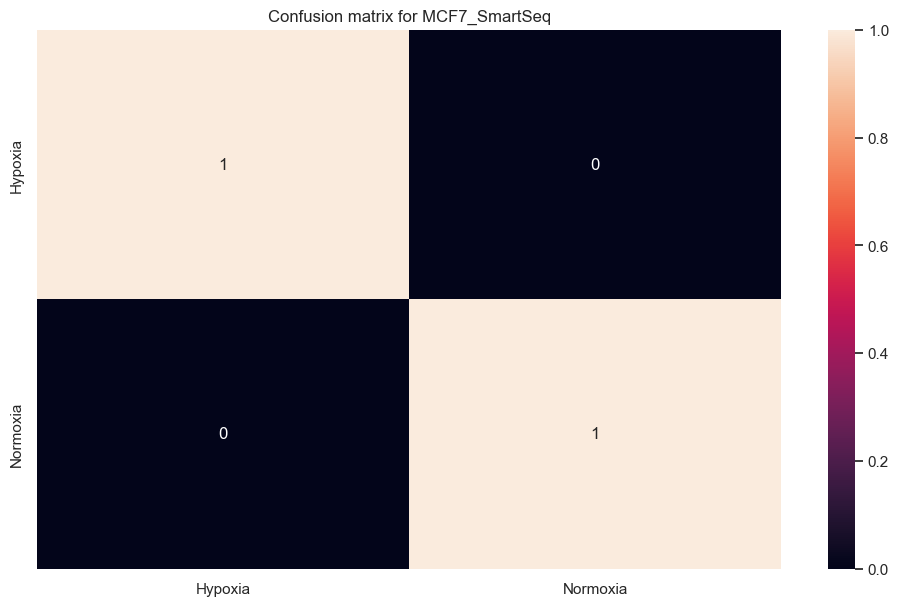

Evaluating the performance on the test set for HCC1806_SmartSeq:

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


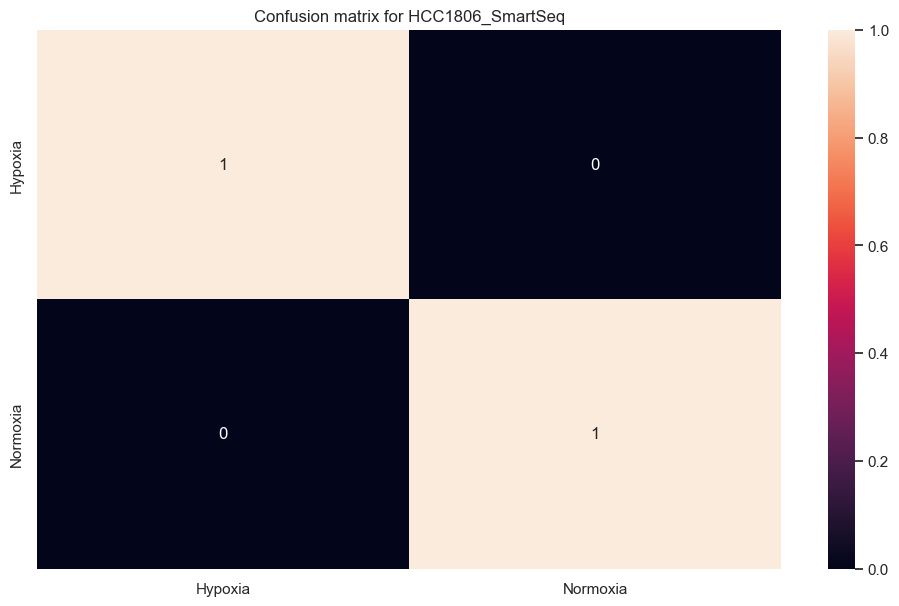

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for MCF7_DropSeq:

Accuracy: 0.9699491447064262
F1: 0.9747180085569818
Precision: 0.9683153013910355
Recall: 0.9812059514487079


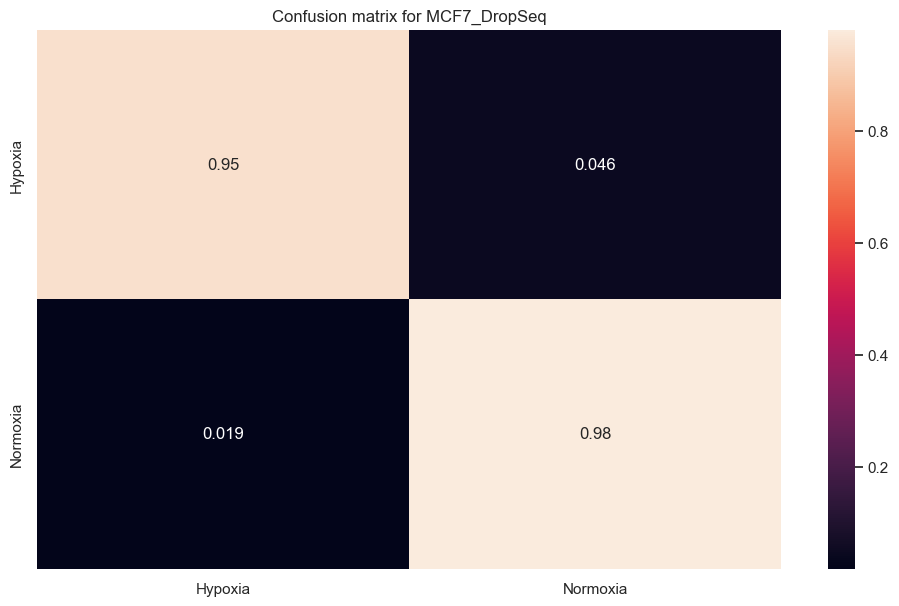

Evaluating the performance on the test set for HCC1806_DropSeq:

Accuracy: 0.9410963568266939
F1: 0.9275847634993721
Precision: 0.9037520391517129
Recall: 0.9527085124677558


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


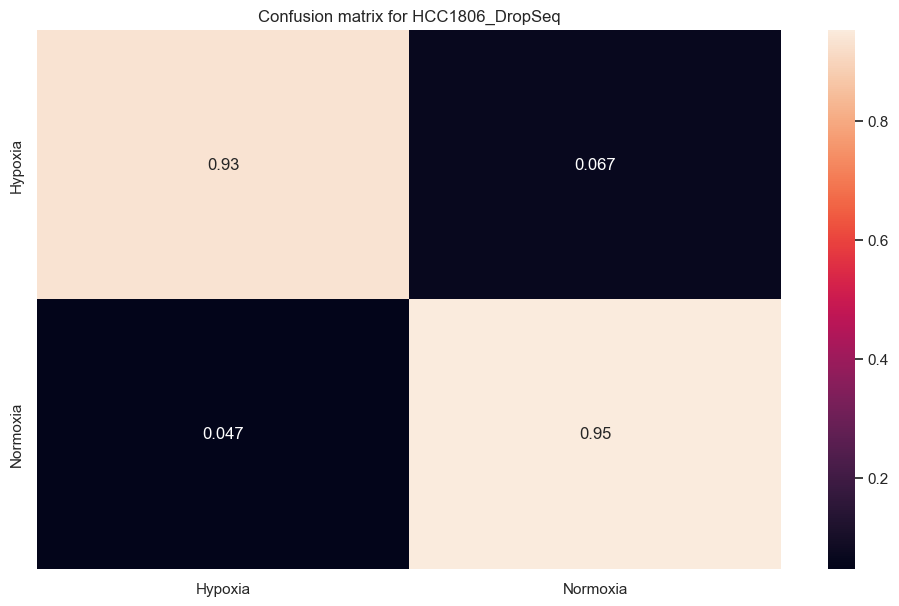

In [22]:
for name, df in datasets.items():
    # load the model
    model_name = f'sgd_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name], probability=False)